# P4: Construisez un modèle de scoring
<img src="img/oc.png" width="300" height="300"/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import scipy.stats as st

# File system manangement
import os

from sklearn import decomposition
from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

from functions import *
from utils import *

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
def plt_barsstats(df, col):
    plt.figure(figsize=(15,8))
    ax = sns.barplot(y=df[col].value_counts(normalize=True), x=df[col].value_counts(normalize=True).index, data=df);
    show_values(ax, space=0.01)
    plt.title('Counting contracts for each {0}'.format(col), fontsize=20);
    plt.ylabel('% of contracts', fontsize=15);
    plt.xlabel('{0}'.format(col), fontsize=15);
    plt.show();

    plt.figure(figsize=(15,8))
    ax = sns.barplot( x=col, y ='TARGET', data=df)#, order=df[col]);
    show_values(ax, space=0.1)
    plt.title('Percent of not repayed contracts', fontsize=20);
    plt.ylabel('Percent of TARGET with value = 1', fontsize=15);
    plt.xlabel('{0}'.format(col), fontsize=15);
    plt.show();

# Importation des données
## Data description

There are 7 different sources of data:

 - application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.
 - bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
 - bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
 - previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
 - POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
 - credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
 - installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.
 
 A breaf explanation of the data and it's organization in different files can be seen in the following image:
 
 <img src="img/home_credit.png" width="1000" height="800"/>
 
 
`SK_ID_CURR` is connecting the dataframes application_train and application_test with bureau, previous_application, POS_CASH_BALANCE. installments_payment and credit_card_balance. `SK_ID_PREV` connects dataframe previous_application with POS_CASH_balance, installments_payment and credit_card_balance. `SK_ID_BUREAU` connects dataframe bureau with dataframe bureau_balance.

In [3]:
# List files available
for file in os.listdir("ProjetMiseenProd_home_credit_default_risk/"):
    print(file)

application_test.csv
HomeCredit_columns_description.csv
POS_CASH_balance.csv
credit_card_balance.csv
installments_payments.csv
application_train.csv
bureau.csv
previous_application.csv
bureau_balance.csv
sample_submission.csv


### Columns description for all files

In [4]:
df_col_description = pd.read_csv('ProjetMiseenProd_home_credit_default_risk/HomeCredit_columns_description.csv', sep=',', encoding='utf-8', encoding_errors='ignore')
#df = data.copy()
df_col_description.head(5)
df_col_description[~df_col_description.Special.isna()]
del df_col_description

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


,Unnamed: 0,Table,Row,Description,Special
16,19,application_{train|test}.csv,REGION_POPULATION_RELATIVE,Normalized population of region where client l...,normalized
17,20,application_{train|test}.csv,DAYS_BIRTH,Client's age in days at the time of application,time only relative to the application
18,21,application_{train|test}.csv,DAYS_EMPLOYED,How many days before the application the perso...,time only relative to the application
19,22,application_{train|test}.csv,DAYS_REGISTRATION,How many days before the application did clien...,time only relative to the application
20,23,application_{train|test}.csv,DAYS_ID_PUBLISH,How many days before the application did clien...,time only relative to the application
...,...,...,...,...,...
209,212,previous_application.csv,DAYS_TERMINATION,Relative to application date of current applic...,time only relative to the application
211,214,installments_payments.csv,SK_ID_PREV,ID of previous credit in Home credit related t...,hashed
212,215,installments_payments.csv,SK_ID_CURR,ID of loan in our sample,hashed
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application


### Application train : `df_train`

In [5]:
df_train = pd.read_csv('ProjetMiseenProd_home_credit_default_risk/application_train.csv')
#df = data.copy()
df_train.head(5)
# quantité des données
print('Les quantité des données')
df_train.shape

# regarder les type des variable
print('Les type observé pour chaque variable')
df_train.dtypes

print('Conté les type des variables')
df_train.dtypes.value_counts()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Les quantité des données


(307511, 122)

Les type observé pour chaque variable


SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

Conté les type des variables


float64    65
int64      41
object     16
dtype: int64

In [6]:
# afficher les valeurs unique pour chaque variable
df_train.nunique()

SK_ID_CURR                    307511
TARGET                             2
NAME_CONTRACT_TYPE                 2
CODE_GENDER                        3
FLAG_OWN_CAR                       2
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY          9
AMT_REQ_CREDIT_BUREAU_WEEK         9
AMT_REQ_CREDIT_BUREAU_MON         24
AMT_REQ_CREDIT_BUREAU_QRT         11
AMT_REQ_CREDIT_BUREAU_YEAR        25
Length: 122, dtype: int64

In [7]:
df_train.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables!

In [8]:
df_train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

### Application test : `df_test`

In [8]:
df_test = pd.read_csv('ProjetMiseenProd_home_credit_default_risk/application_test.csv')
#df = data.copy()
df_test.head(5)
# quantité des données
print('Les quantité des données')
df_test.shape

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Les quantité des données


(48744, 121)

### Bureau balance : `df_bureau_balance`

In [9]:
df_bureau_balance = pd.read_csv('ProjetMiseenProd_home_credit_default_risk/bureau_balance.csv')
df_bureau_balance.head()
# quantité des données
print('Les quantité des données')
df_bureau_balance.shape

# regarder les type des variable
print('Les type observé pour chaque variable')
df_bureau_balance.dtypes

print('Conté les type des variables')
df_bureau_balance.dtypes.value_counts()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Les quantité des données


(27299925, 3)

Les type observé pour chaque variable


SK_ID_BUREAU       int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object

Conté les type des variables


int64     2
object    1
dtype: int64

### Bureau : `df_bureau`

In [10]:
df_bureau = pd.read_csv('ProjetMiseenProd_home_credit_default_risk/bureau.csv')
df_bureau.head()
# quantité des données
print('Les quantité des données')
df_bureau.shape

# regarder les type des variable
print('Les type observé pour chaque variable')
df_bureau.dtypes

print('Conté les type des variables')
df_bureau.dtypes.value_counts()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


Les quantité des données


(1716428, 17)

Les type observé pour chaque variable


SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object

Conté les type des variables


float64    8
int64      6
object     3
dtype: int64

### Credit card balance : `df_credit_card_balance`

In [11]:
df_credit_card_balance = pd.read_csv('ProjetMiseenProd_home_credit_default_risk/credit_card_balance.csv')
df_credit_card_balance.head()
# quantité des données
print('Les quantité des données')
df_credit_card_balance.shape

# regarder les type des variable
print('Les type observé pour chaque variable')
df_credit_card_balance.dtypes

print('Conté les type des variables')
df_credit_card_balance.dtypes.value_counts()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


Les quantité des données


(3840312, 23)

Les type observé pour chaque variable


SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
dtype: object

Conté les type des variables


float64    15
int64       7
object      1
dtype: int64

### Installments payments : `df_installments_payments`

In [12]:
df_installments_payments = pd.read_csv('ProjetMiseenProd_home_credit_default_risk/installments_payments.csv')
df_installments_payments.head()
# quantité des données
print('Les quantité des données')
df_installments_payments.shape

# regarder les type des variable
print('Les type observé pour chaque variable')
df_installments_payments.dtypes

print('Conté les type des variables')
df_installments_payments.dtypes.value_counts()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


Les quantité des données


(13605401, 8)

Les type observé pour chaque variable


SK_ID_PREV                  int64
SK_ID_CURR                  int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER       int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtype: object

Conté les type des variables


float64    5
int64      3
dtype: int64

### POS CASH balance : `df_POS_CASH_balance`

In [13]:
df_POS_CASH_balance = pd.read_csv('ProjetMiseenProd_home_credit_default_risk/POS_CASH_balance.csv')
df_POS_CASH_balance.head()
# quantité des données
print('Les quantité des données')
df_POS_CASH_balance.shape

# regarder les type des variable
print('Les type observé pour chaque variable')
df_POS_CASH_balance.dtypes

print('Conté les type des variables')
df_POS_CASH_balance.dtypes.value_counts()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


Les quantité des données


(10001358, 8)

Les type observé pour chaque variable


SK_ID_PREV                 int64
SK_ID_CURR                 int64
MONTHS_BALANCE             int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS      object
SK_DPD                     int64
SK_DPD_DEF                 int64
dtype: object

Conté les type des variables


int64      5
float64    2
object     1
dtype: int64

### Previous application : `df_previous_application`

In [14]:
df_previous_application = pd.read_csv('ProjetMiseenProd_home_credit_default_risk/previous_application.csv')
df_previous_application.head()
# quantité des données
print('Les quantité des données')
df_previous_application.shape

# regarder les type des variable
print('Les type observé pour chaque variable')
df_previous_application.dtypes

print('Conté les type des variables')
df_previous_application.dtypes.value_counts()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


Les quantité des données


(1670214, 37)

Les type observé pour chaque variable


SK_ID_PREV                       int64
SK_ID_CURR                       int64
NAME_CONTRACT_TYPE              object
AMT_ANNUITY                    float64
AMT_APPLICATION                float64
AMT_CREDIT                     float64
AMT_DOWN_PAYMENT               float64
AMT_GOODS_PRICE                float64
WEEKDAY_APPR_PROCESS_START      object
HOUR_APPR_PROCESS_START          int64
FLAG_LAST_APPL_PER_CONTRACT     object
NFLAG_LAST_APPL_IN_DAY           int64
RATE_DOWN_PAYMENT              float64
RATE_INTEREST_PRIMARY          float64
RATE_INTEREST_PRIVILEGED       float64
NAME_CASH_LOAN_PURPOSE          object
NAME_CONTRACT_STATUS            object
DAYS_DECISION                    int64
NAME_PAYMENT_TYPE               object
CODE_REJECT_REASON              object
NAME_TYPE_SUITE                 object
NAME_CLIENT_TYPE                object
NAME_GOODS_CATEGORY             object
NAME_PORTFOLIO                  object
NAME_PRODUCT_TYPE               object
CHANNEL_TYPE             

Conté les type des variables


object     16
float64    15
int64       6
dtype: int64

# Exploratory Data Analysis

## Examine missing values
### Application train

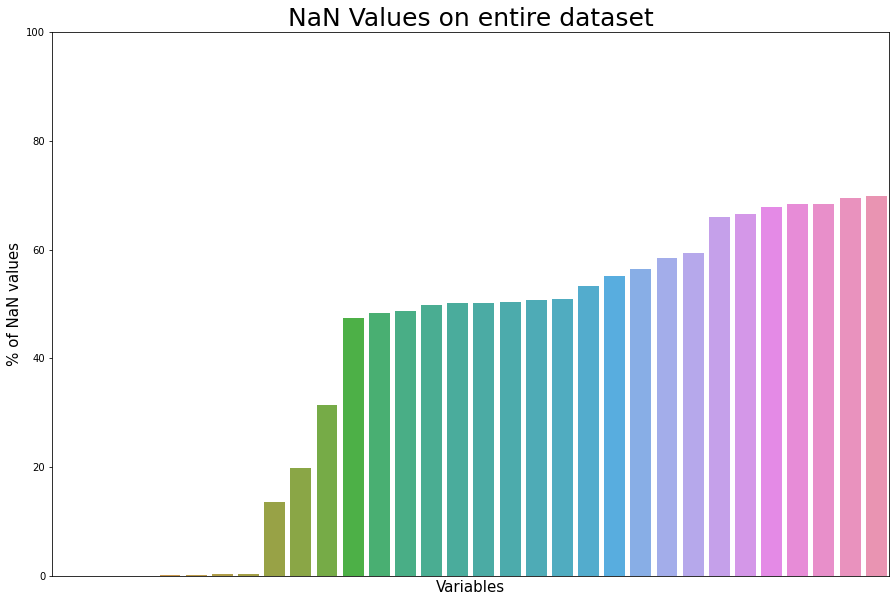

In [15]:
plot_nan_in_pourcent_from_data(df_train)

In [16]:
# Missing values statistics
missing_values = missing_values_table(df_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


### Application test

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


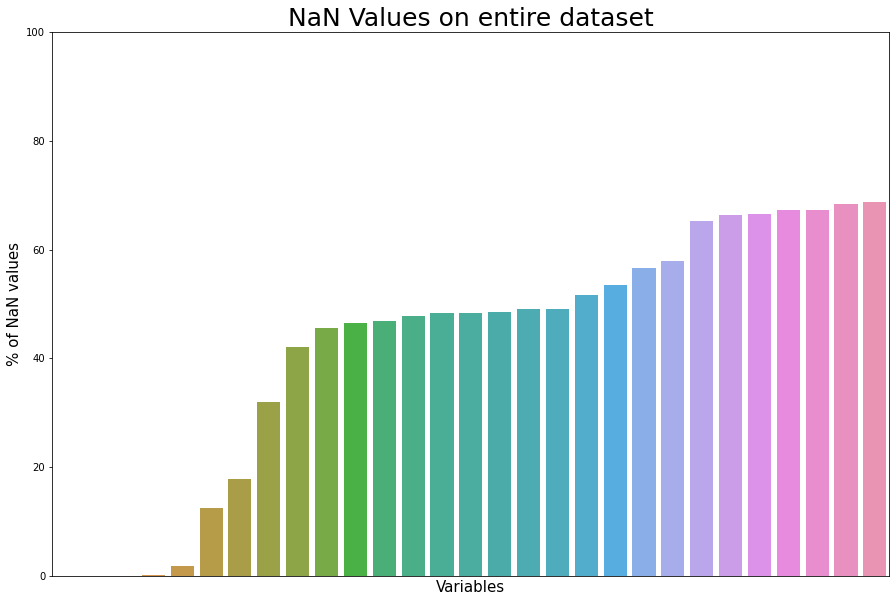

In [17]:
plot_nan_in_pourcent_from_data(df_test)
# Missing values statistics
missing_values = missing_values_table(df_train)
missing_values.head(20)

### Bureau balance 

In [18]:
# Missing values statistics
missing_values = missing_values_table(df_bureau_balance)

Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


### Bureau

Your selected dataframe has 17 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
AMT_ANNUITY,1226791,71.5
AMT_CREDIT_MAX_OVERDUE,1124488,65.5
DAYS_ENDDATE_FACT,633653,36.9
AMT_CREDIT_SUM_LIMIT,591780,34.5
AMT_CREDIT_SUM_DEBT,257669,15.0
DAYS_CREDIT_ENDDATE,105553,6.1
AMT_CREDIT_SUM,13,0.0


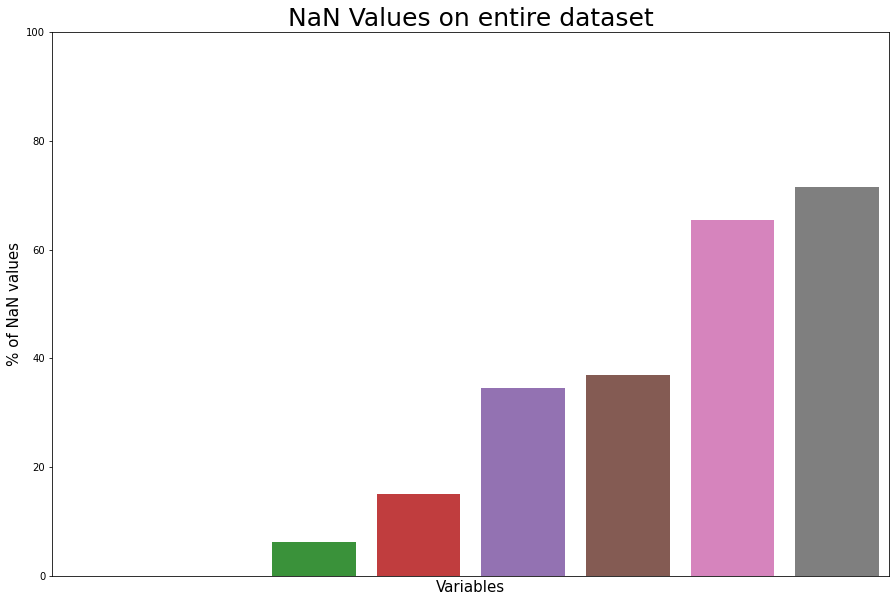

In [19]:
plot_nan_in_pourcent_from_data(df_bureau)
# Missing values statistics
missing_values = missing_values_table(df_bureau)
missing_values

### Creadit card balance

Your selected dataframe has 23 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
AMT_PAYMENT_CURRENT,767988,20.0
AMT_DRAWINGS_ATM_CURRENT,749816,19.5
AMT_DRAWINGS_OTHER_CURRENT,749816,19.5
AMT_DRAWINGS_POS_CURRENT,749816,19.5
CNT_DRAWINGS_ATM_CURRENT,749816,19.5
CNT_DRAWINGS_OTHER_CURRENT,749816,19.5
CNT_DRAWINGS_POS_CURRENT,749816,19.5
AMT_INST_MIN_REGULARITY,305236,7.9
CNT_INSTALMENT_MATURE_CUM,305236,7.9


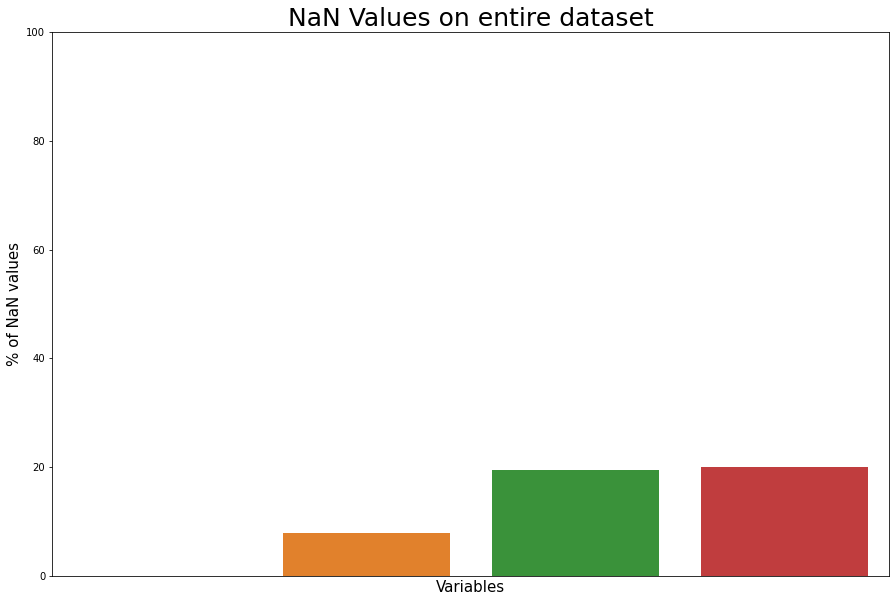

In [20]:
plot_nan_in_pourcent_from_data(df_credit_card_balance)
# Missing values statistics
missing_values = missing_values_table(df_credit_card_balance)
missing_values

### Installments payments

In [21]:
# Missing values statistics
missing_values = missing_values_table(df_installments_payments)
missing_values

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
DAYS_ENTRY_PAYMENT,2905,0.0
AMT_PAYMENT,2905,0.0


### POS Cash balance

In [22]:
# Missing values statistics
missing_values = missing_values_table(df_POS_CASH_balance)
missing_values

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
CNT_INSTALMENT_FUTURE,26087,0.3
CNT_INSTALMENT,26071,0.3


### Previous application

Your selected dataframe has 37 columns.
There are 16 columns that have missing values.


,Missing Values,% of Total Values
RATE_INTEREST_PRIMARY,1664263,99.6
RATE_INTEREST_PRIVILEGED,1664263,99.6
AMT_DOWN_PAYMENT,895844,53.6
RATE_DOWN_PAYMENT,895844,53.6
NAME_TYPE_SUITE,820405,49.1
DAYS_FIRST_DRAWING,673065,40.3
DAYS_FIRST_DUE,673065,40.3
DAYS_LAST_DUE_1ST_VERSION,673065,40.3
DAYS_LAST_DUE,673065,40.3
DAYS_TERMINATION,673065,40.3


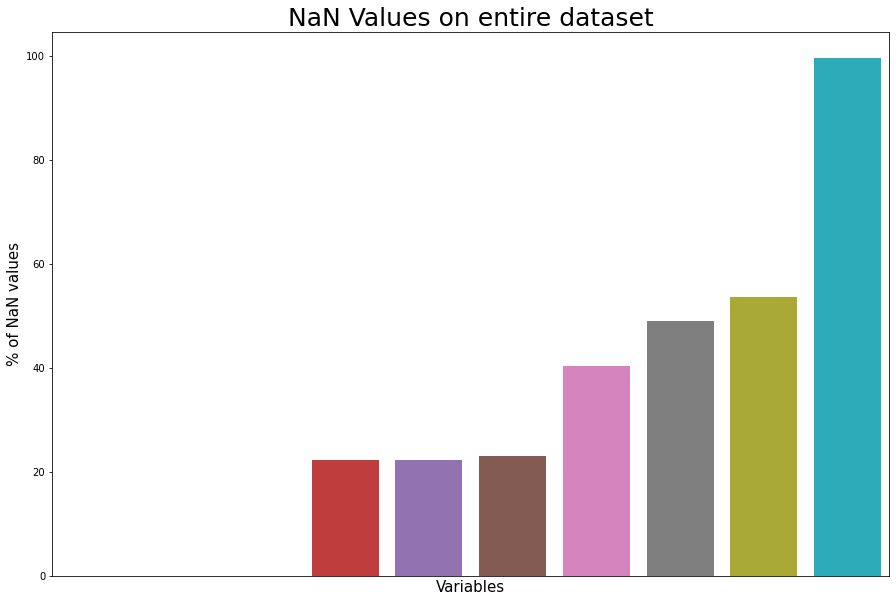

In [23]:
plot_nan_in_pourcent_from_data(df_previous_application)
# Missing values statistics
missing_values = missing_values_table(df_previous_application)
missing_values.head(20)

## Univariate data analysis

### Examine unbalanced data : `TARGET` column

First we need to understand the target variable.
 - 0 means loan is repayed
 - 1 means loan is not repayed

In [6]:
df_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

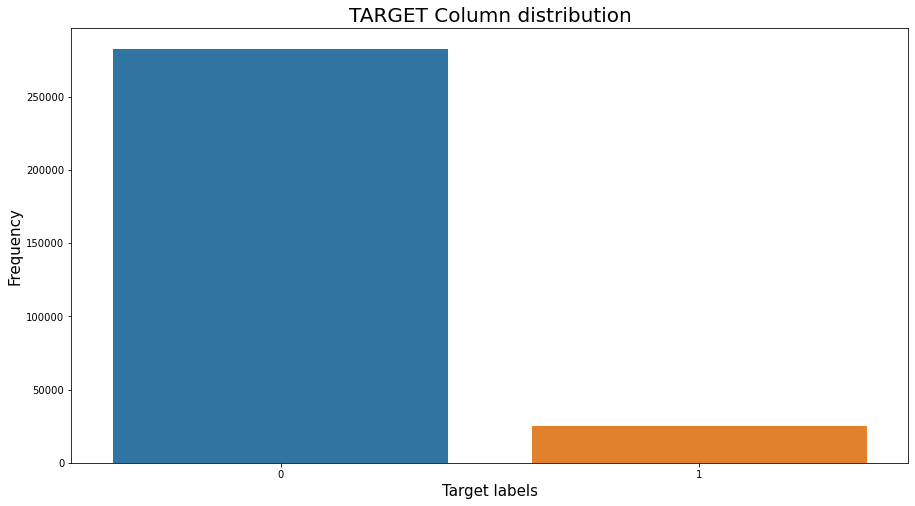

In [7]:
plt.figure(figsize=(15,8))
sns.barplot(x = df_train.TARGET.value_counts().index, y = df_train.TARGET.value_counts(), data = df_train)
plt.title('TARGET Column distribution', fontsize=20);
plt.xlabel('Target labels', fontsize=15);
plt.ylabel('Frequency', fontsize=15);
plt.show();

### Contract types

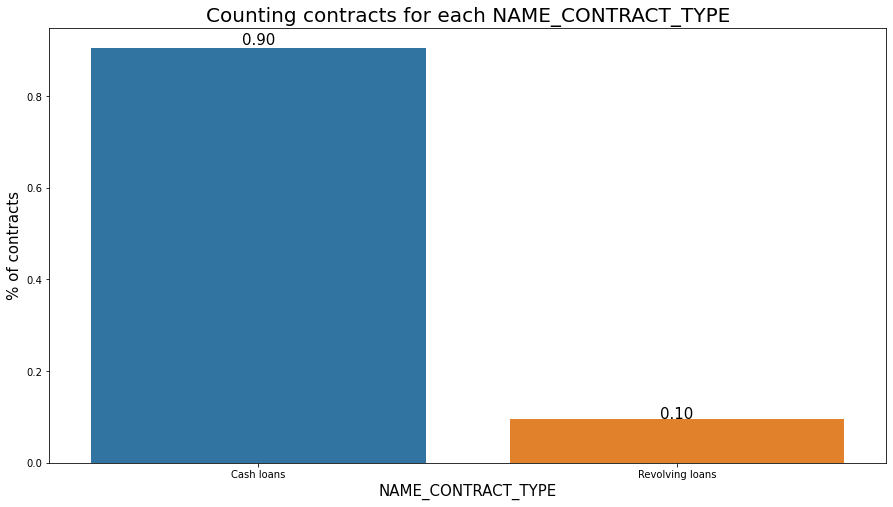

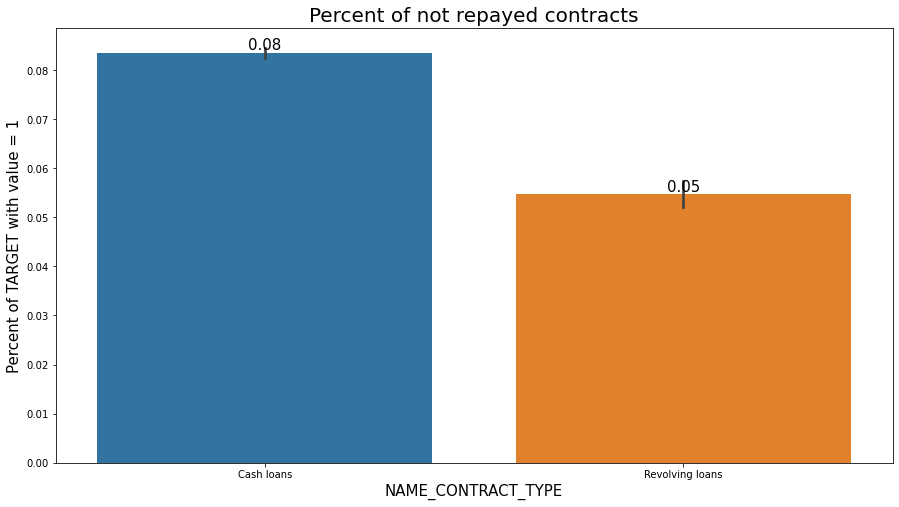

In [9]:
plt_barsstats(df_train, 'NAME_CONTRACT_TYPE')

Now we easly can say that the we have 2 types of contract. First the cash lioans with about 90% and second the Revolving loans with about 10% of contracts. So we naturally ask ourselfs ***how much of them are not repayed?*** Observe that cash loans are about 8% not repayed comparing to 5% not repaued revolving loans contracts.

### Client gender

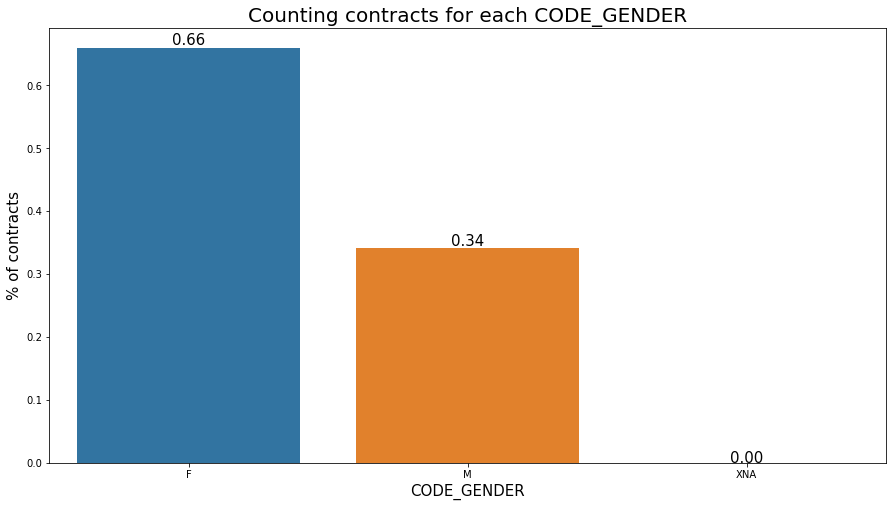

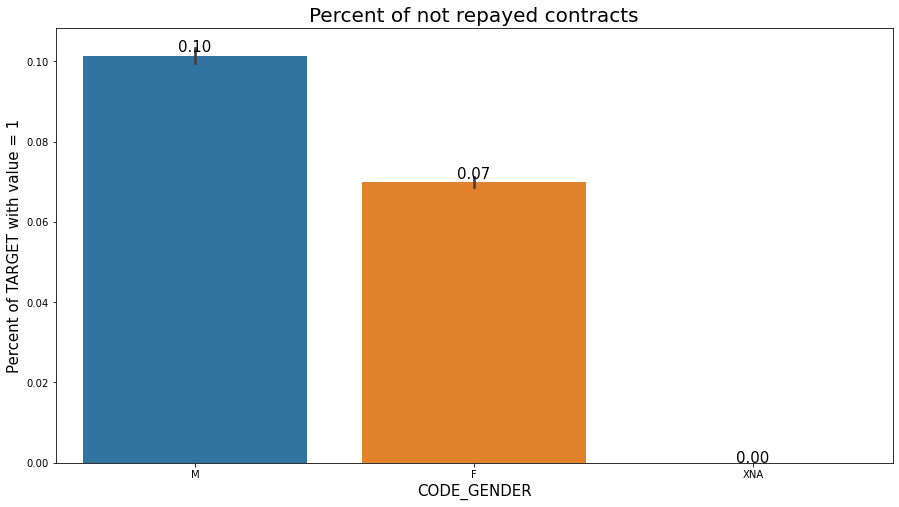

In [10]:
plt_barsstats(df_train, 'CODE_GENDER')

Observe about 66% of contracts are made by women ad 34% are made by men. ***But how much of contracts are repayed for each gender?*** We can affirm that unpayed contracts are about 10% for men and 7% for women.

### Owning car

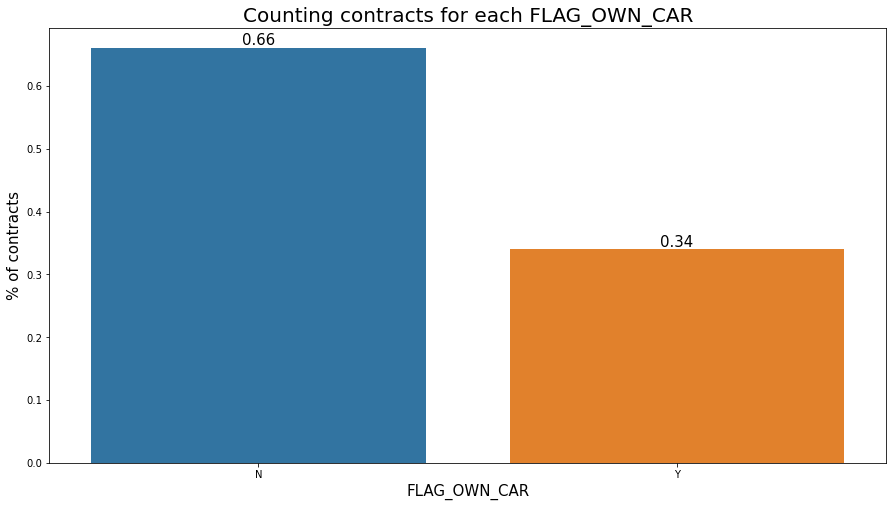

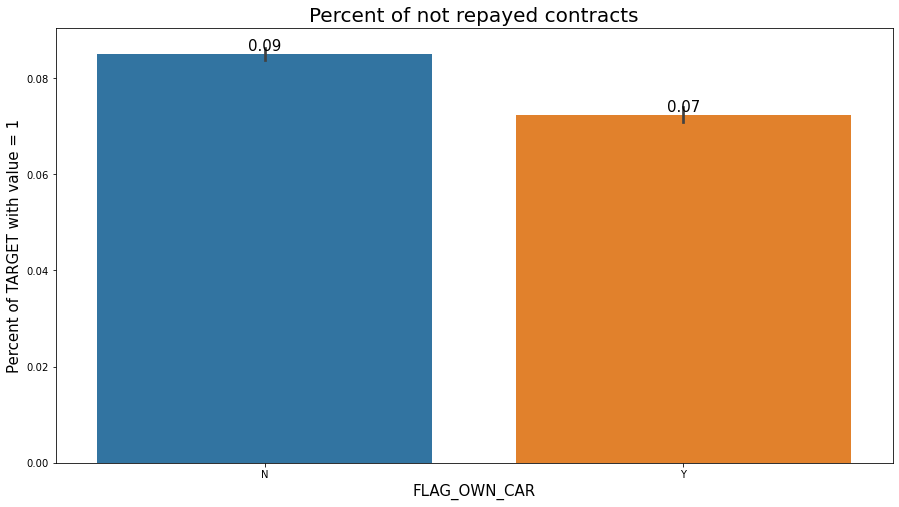

In [11]:
plt_barsstats(df_train, 'FLAG_OWN_CAR')

We can observe that about 35% of owned car persons has contracts comparing to 66% of persons not owning car. Despite this 7% of persons owning cars are with unpayed loans and 9% of persons not owning cars are with unpayed loans.

### Owning a real estate 

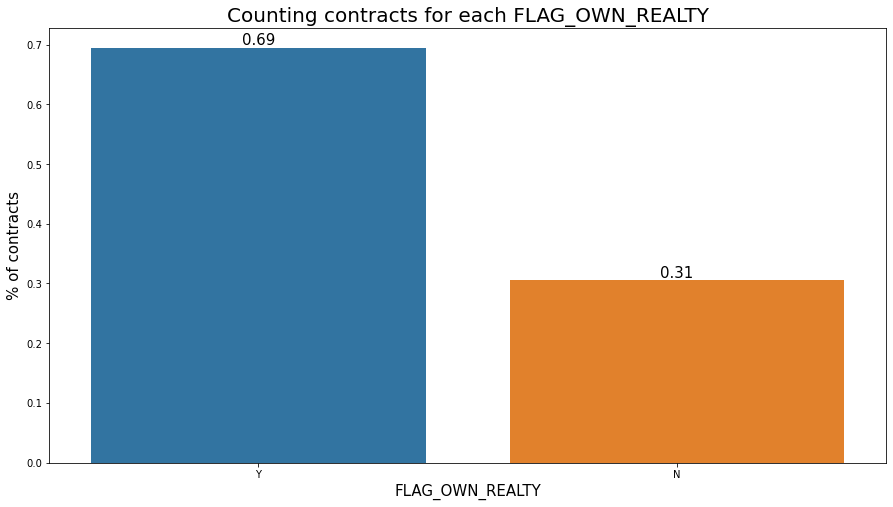

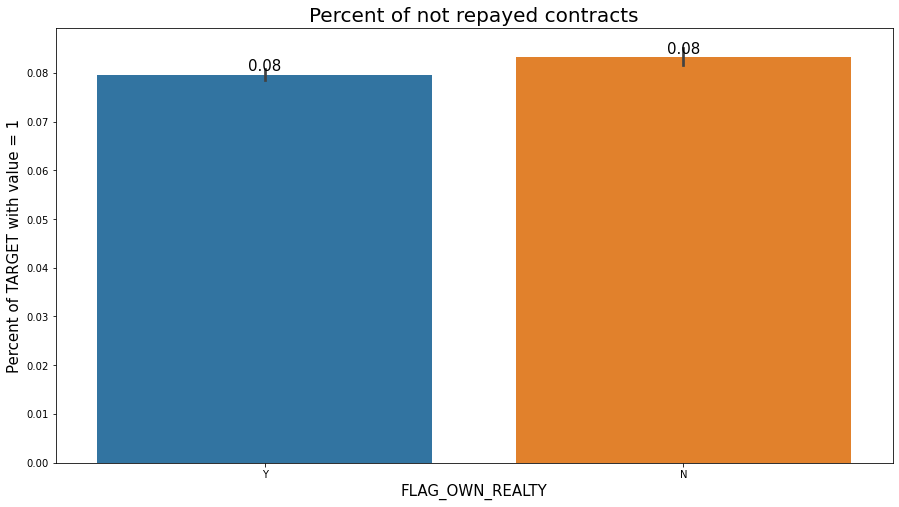

In [12]:
plt_barsstats(df_train, 'FLAG_OWN_REALTY')

### Owning house type

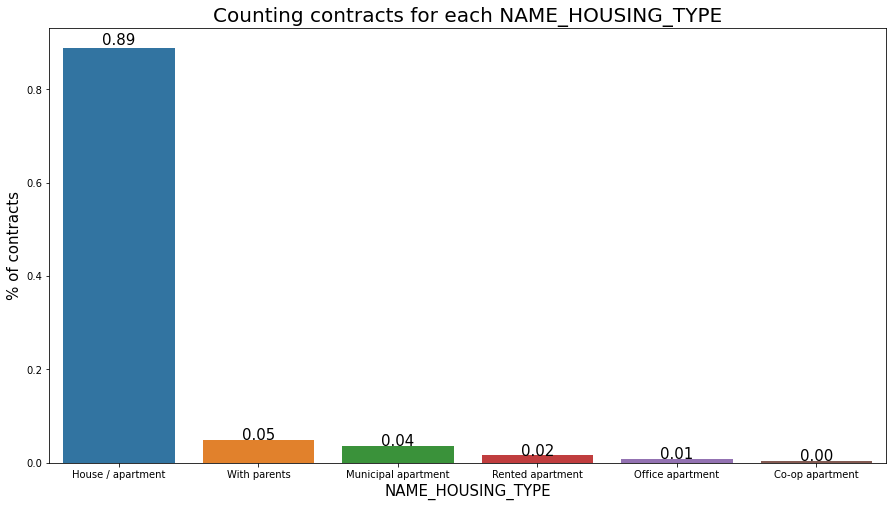

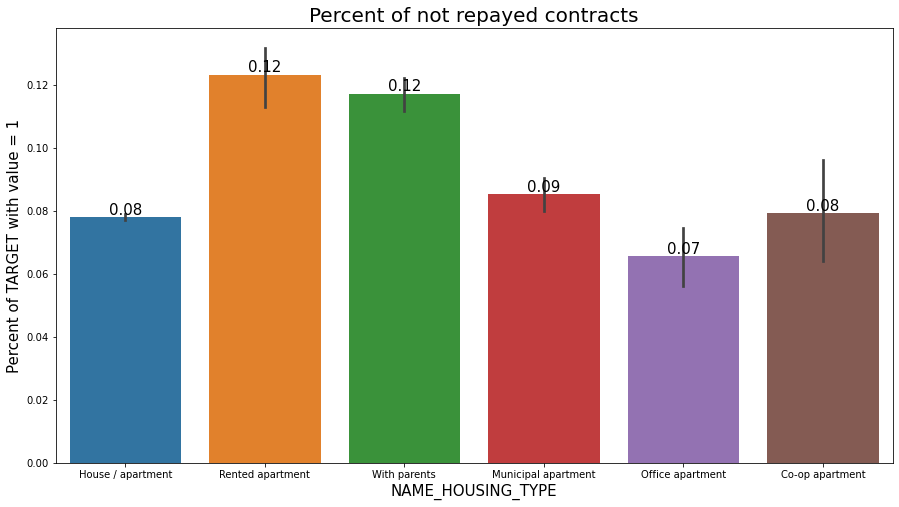

In [14]:
plt_barsstats(df_train, 'NAME_HOUSING_TYPE')

We can observe that the most of the persons which is 89% owning a house/appartment has loan contracts. 
8% of loan contracts with persons that own a house/appartment are not repayed.

### Family status

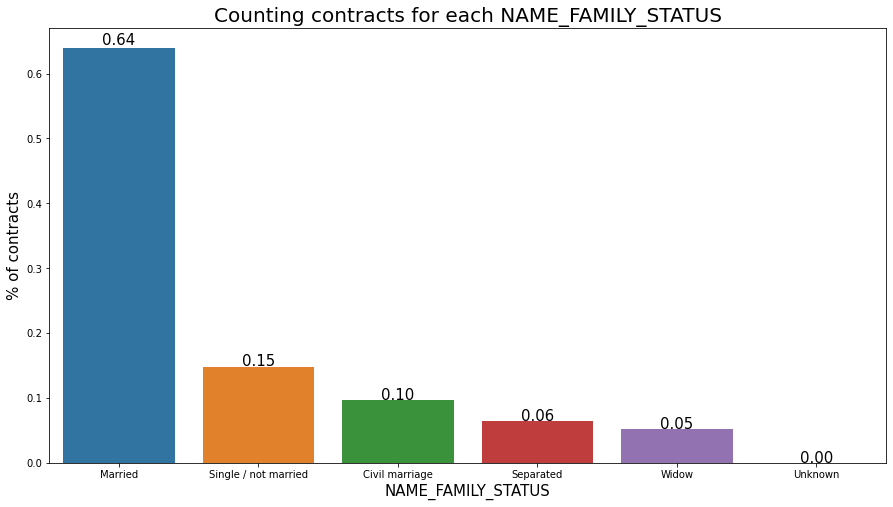

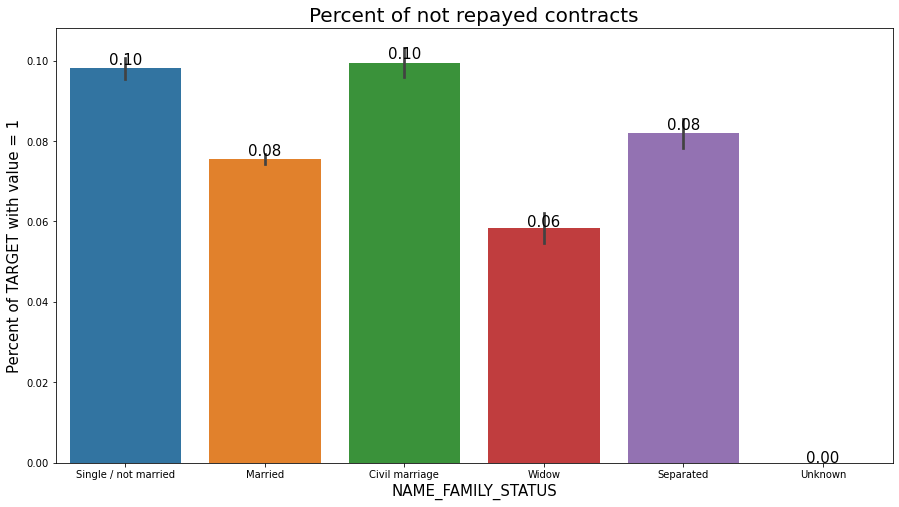

In [13]:
plt_barsstats(df_train, 'NAME_FAMILY_STATUS')

We can see that the most contracts are made by the clients with married status with about 64%, followed by the single and civil marriage with about 15% and 10% respectivelly. Also we say that the single and the civil marriage are more contracts that not repayment with 10% than thoose with married status.

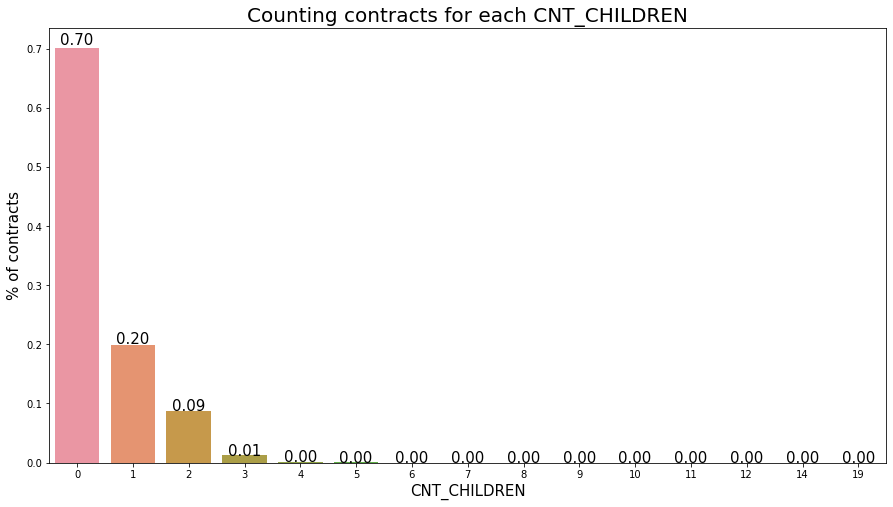

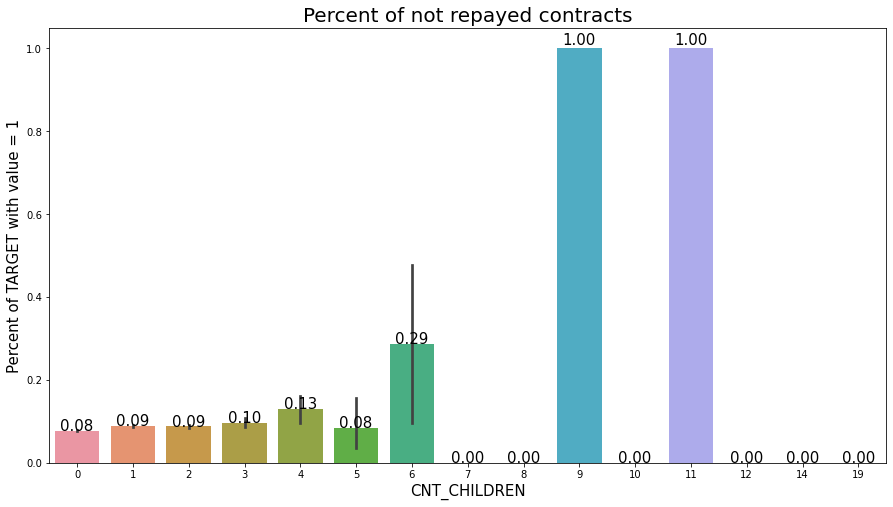

In [15]:
plt_barsstats(df_train, 'CNT_CHILDREN')

Most clients with loan contracts have no children. Theese are 70% of contracts. Thoose that are with 1, 2 and 3 childrens are with 20%, 9% and 1% respectivelly.

One can observe that families with 9 and 11 childers have loans not repayed, despite the families with 0, 1, 2, 3 and 5 childrens that have 10% of not repayed loans. Families with 6 childrens have 28% of loan contracts not repayed.

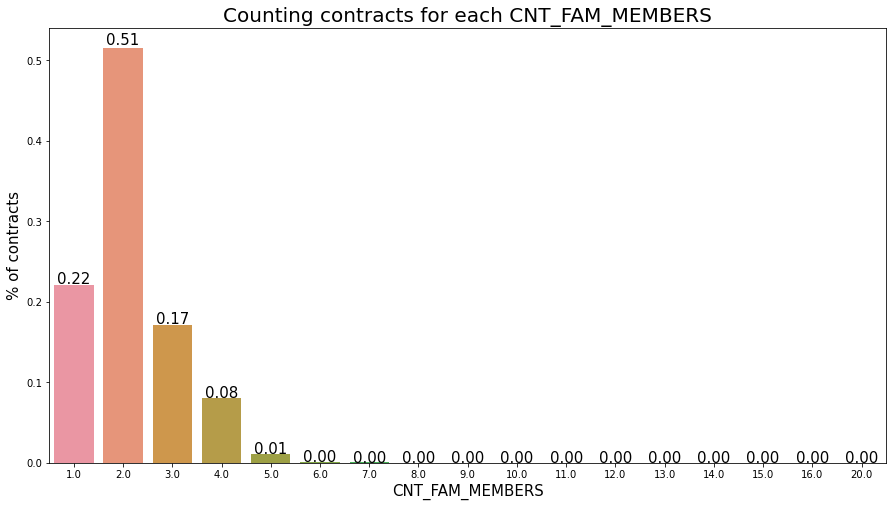

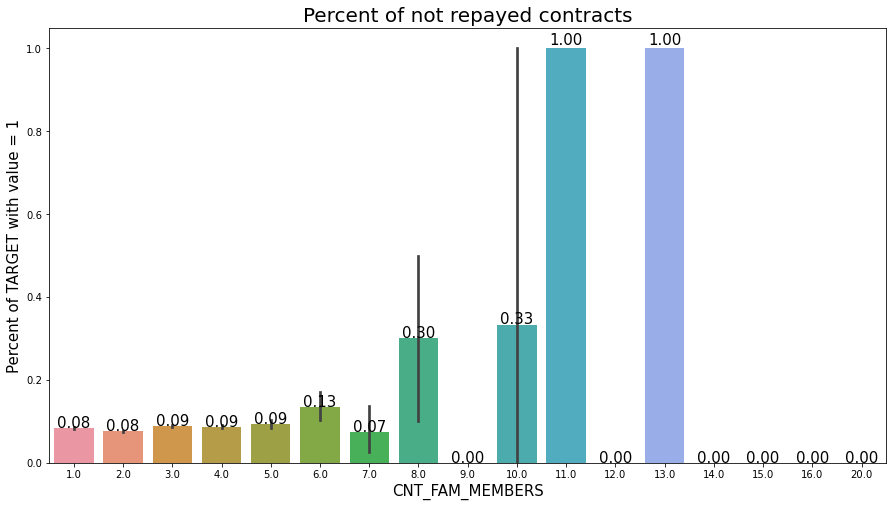

In [16]:
plt_barsstats(df_train, 'CNT_FAM_MEMBERS')

We see a consistence with the number of childrens in the familly. Thoose that are with 11 and 13 members in family are with 100% loans not repayed.

### Income type

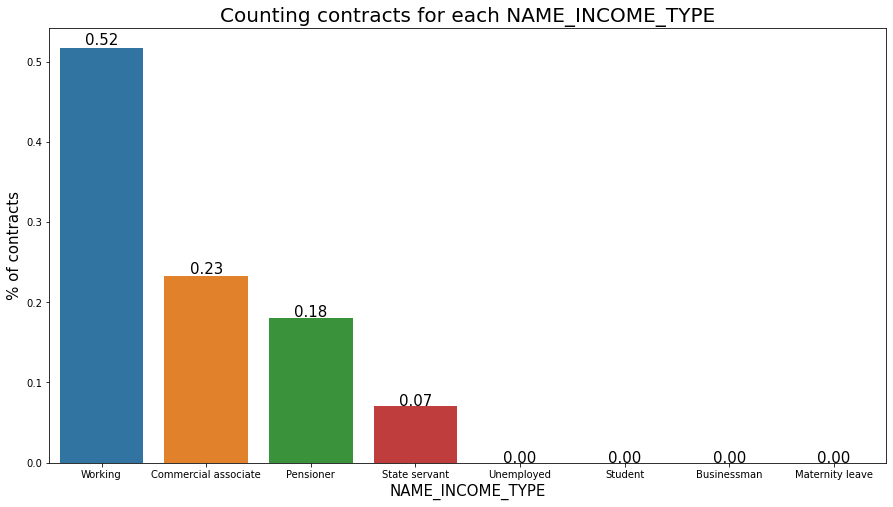

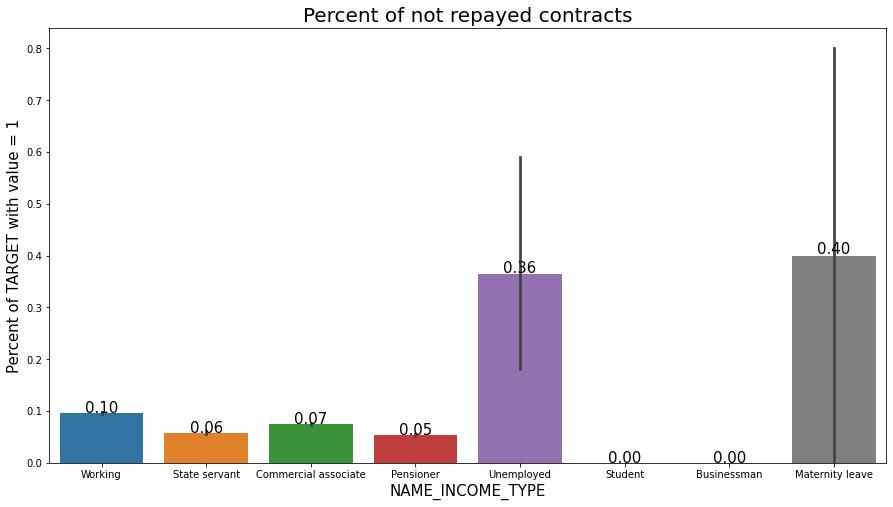

In [17]:
plt_barsstats(df_train, 'NAME_INCOME_TYPE')

The most loans have the working clients 50%. Theese have 10% of loans not repayed.
Also observe commercial assistance, pensioners, and state servant with 23%, 18% and 7% loans respectively.
Unemployed and Maternity leave has 36% and 40% of not repayed loans.

### Education type

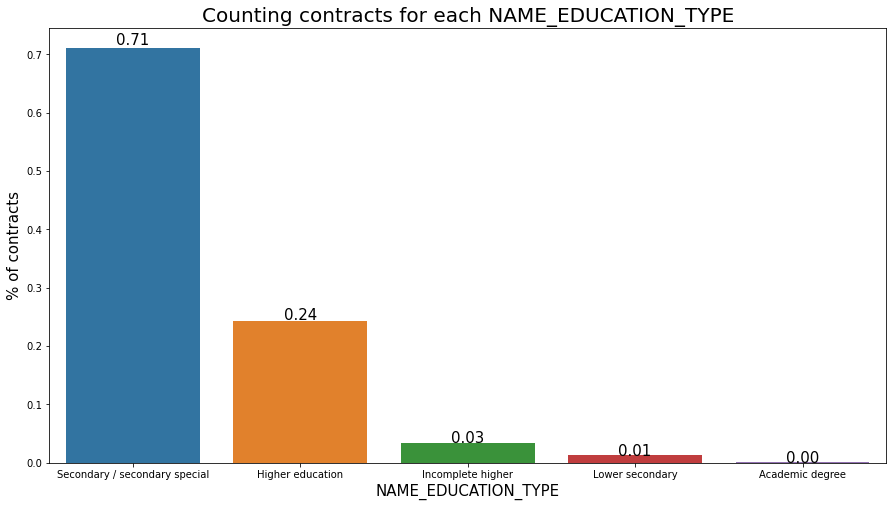

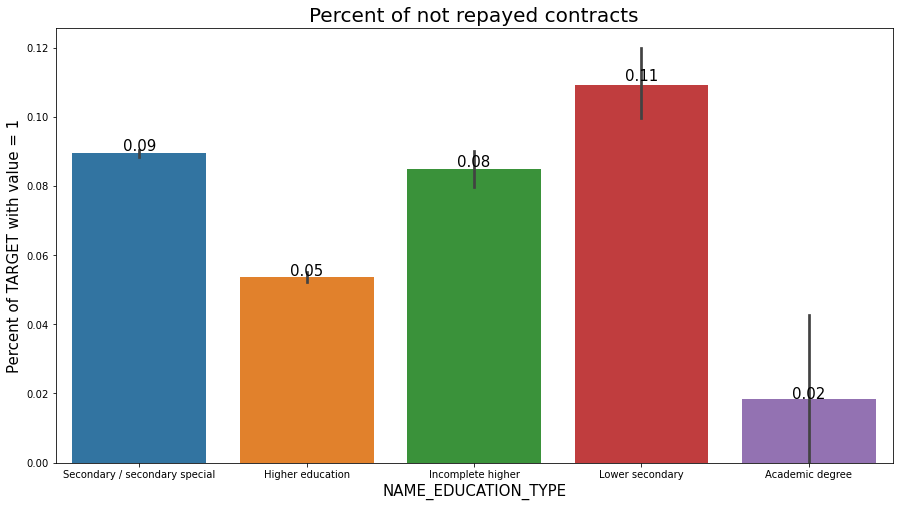

In [21]:
plt_barsstats(df_train, 'NAME_EDUCATION_TYPE')

Secondary/secondary specias clients education types have 71% of loans, despite the higher education clients with 24% of loans. 

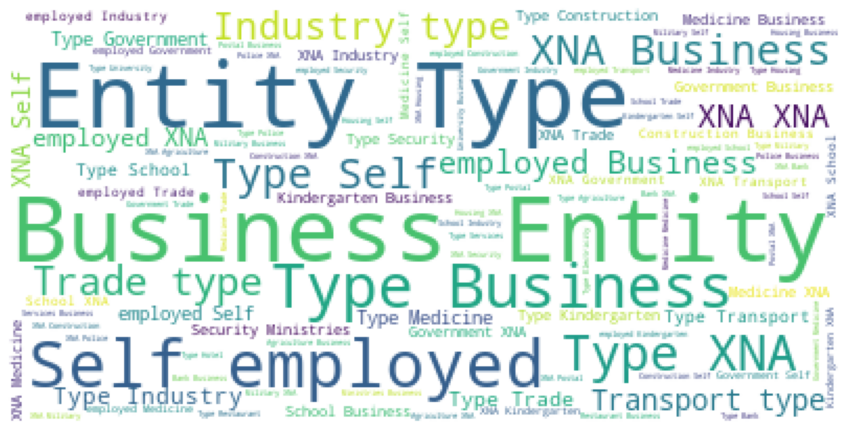

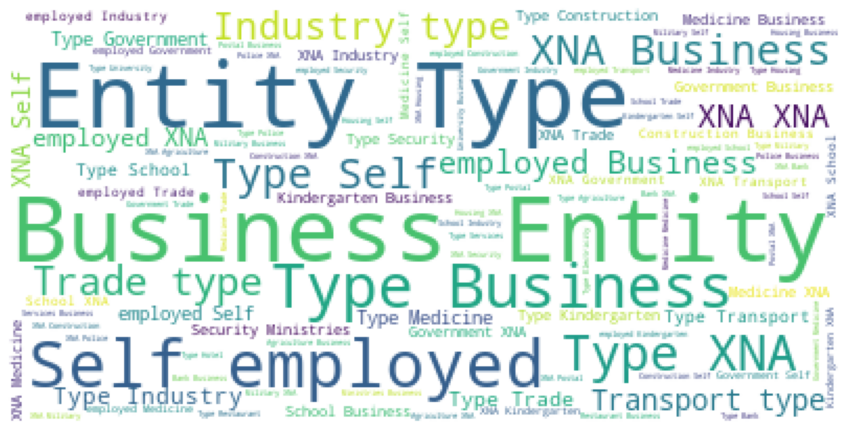

In [22]:
plot_words(df_train, 'ORGANIZATION_TYPE')

### Ploting the distribution of the variables

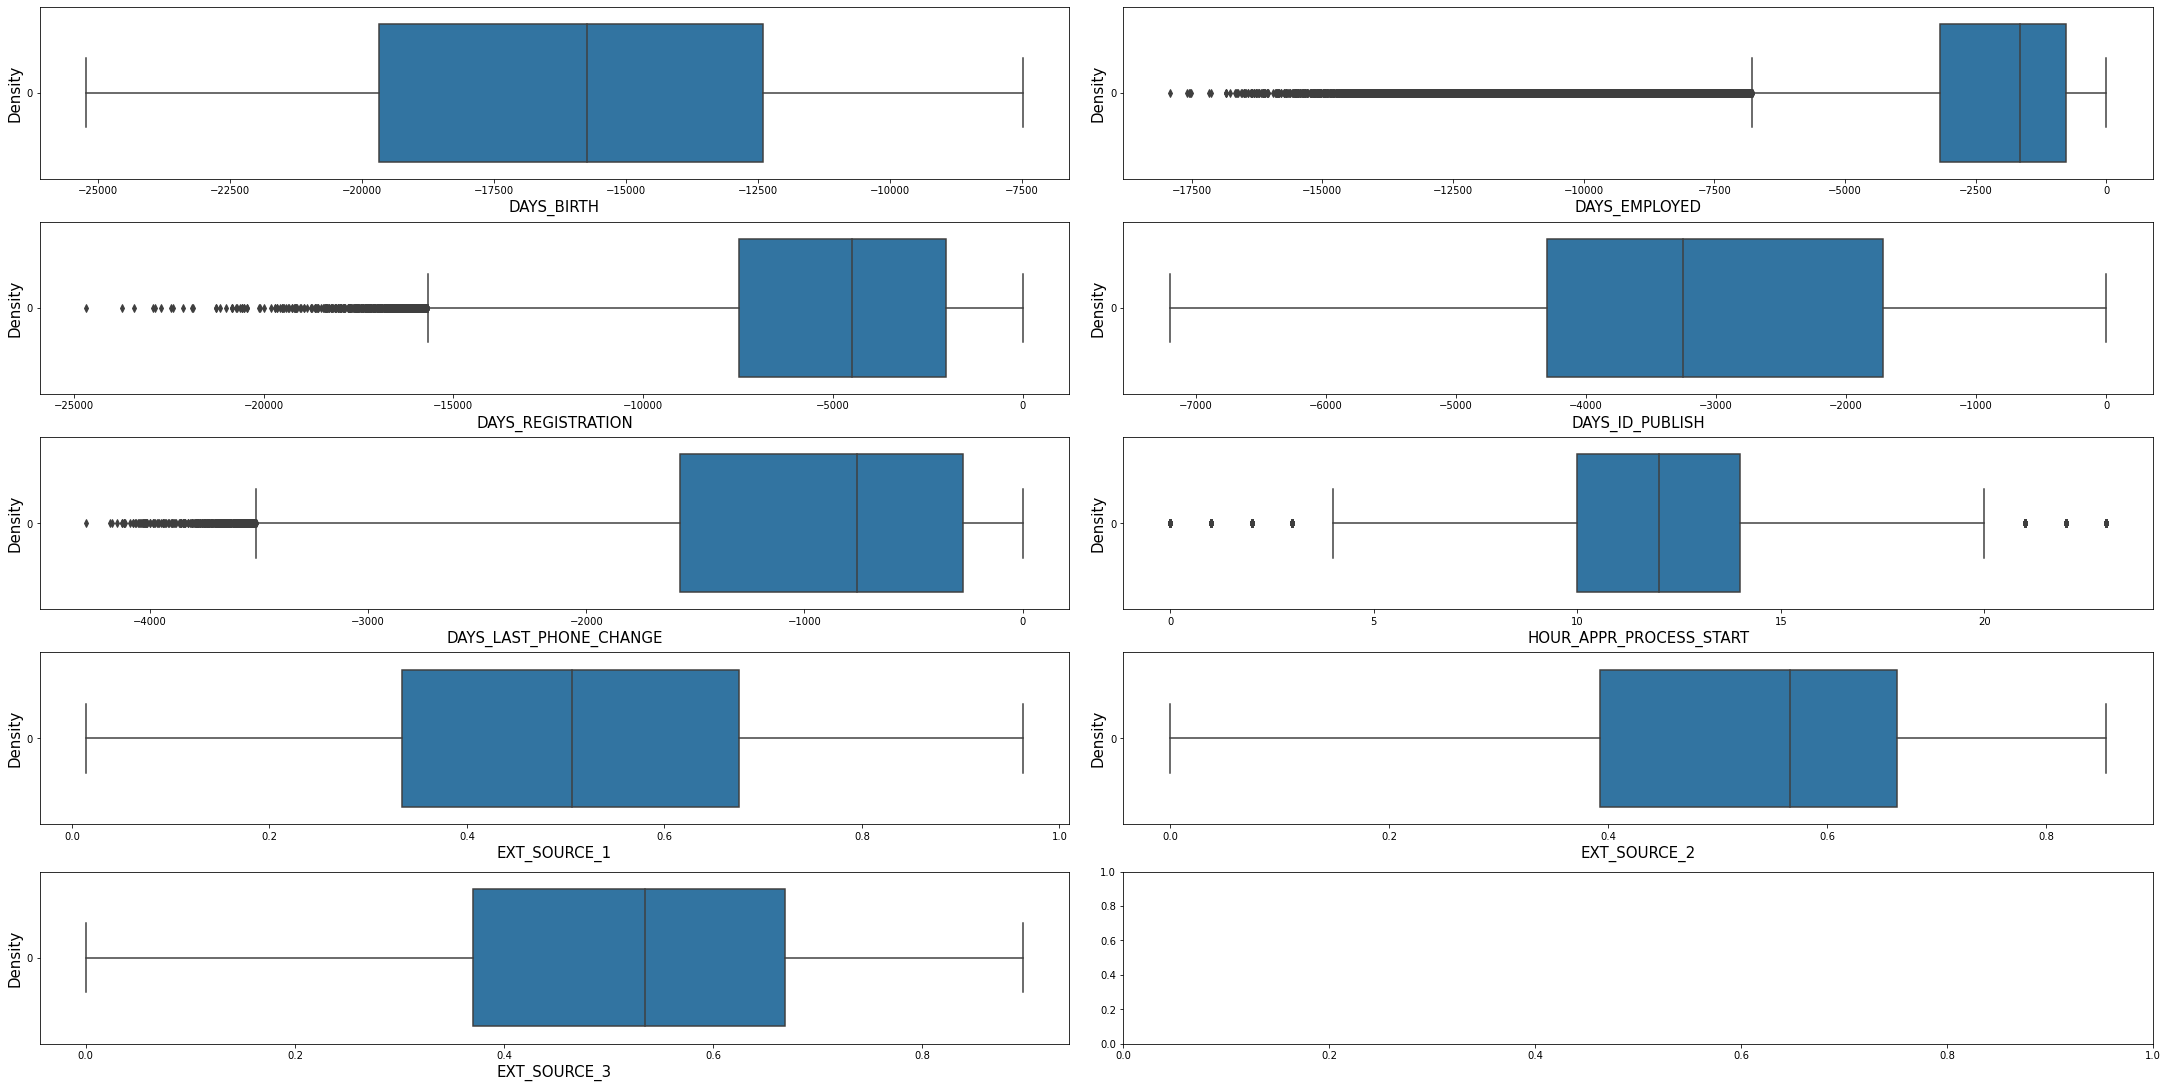

In [31]:
cols = ['DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE',
       'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3']

plot_density(df_train, columns = cols, dt = DensityTypes.Boxplot)

The numbers in the `DAYS_BIRTH` column are negative because they are recorded relative to the current loan application.  We can see an outlier in the`DAYS_EMPLOYED`, the value being approximative 100years. We see a normal distribution hear for `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`. Theese values seeams to be ok.

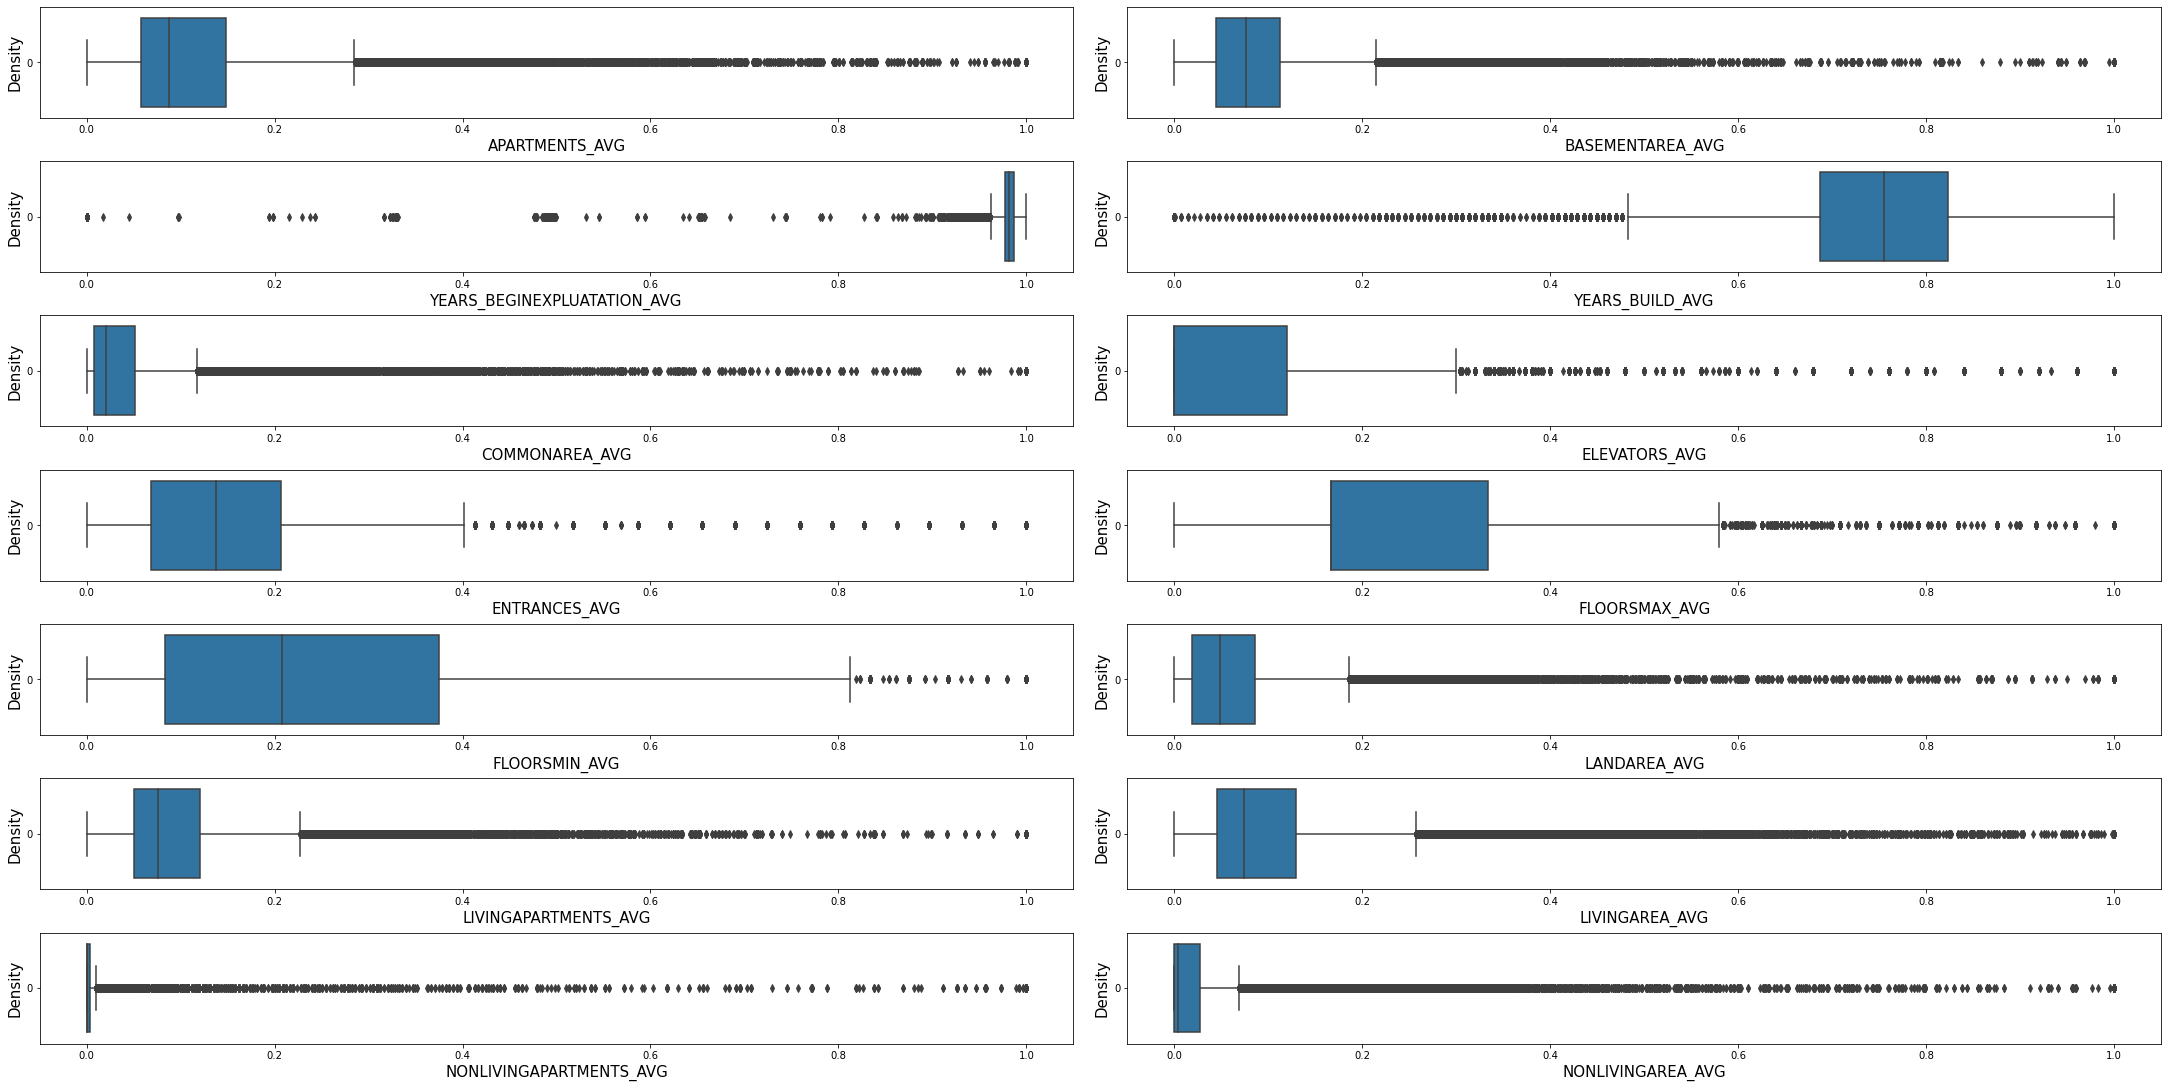

In [26]:
cols = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG']
plot_density(df_train, columns = cols, dt = DensityTypes.Boxplot)

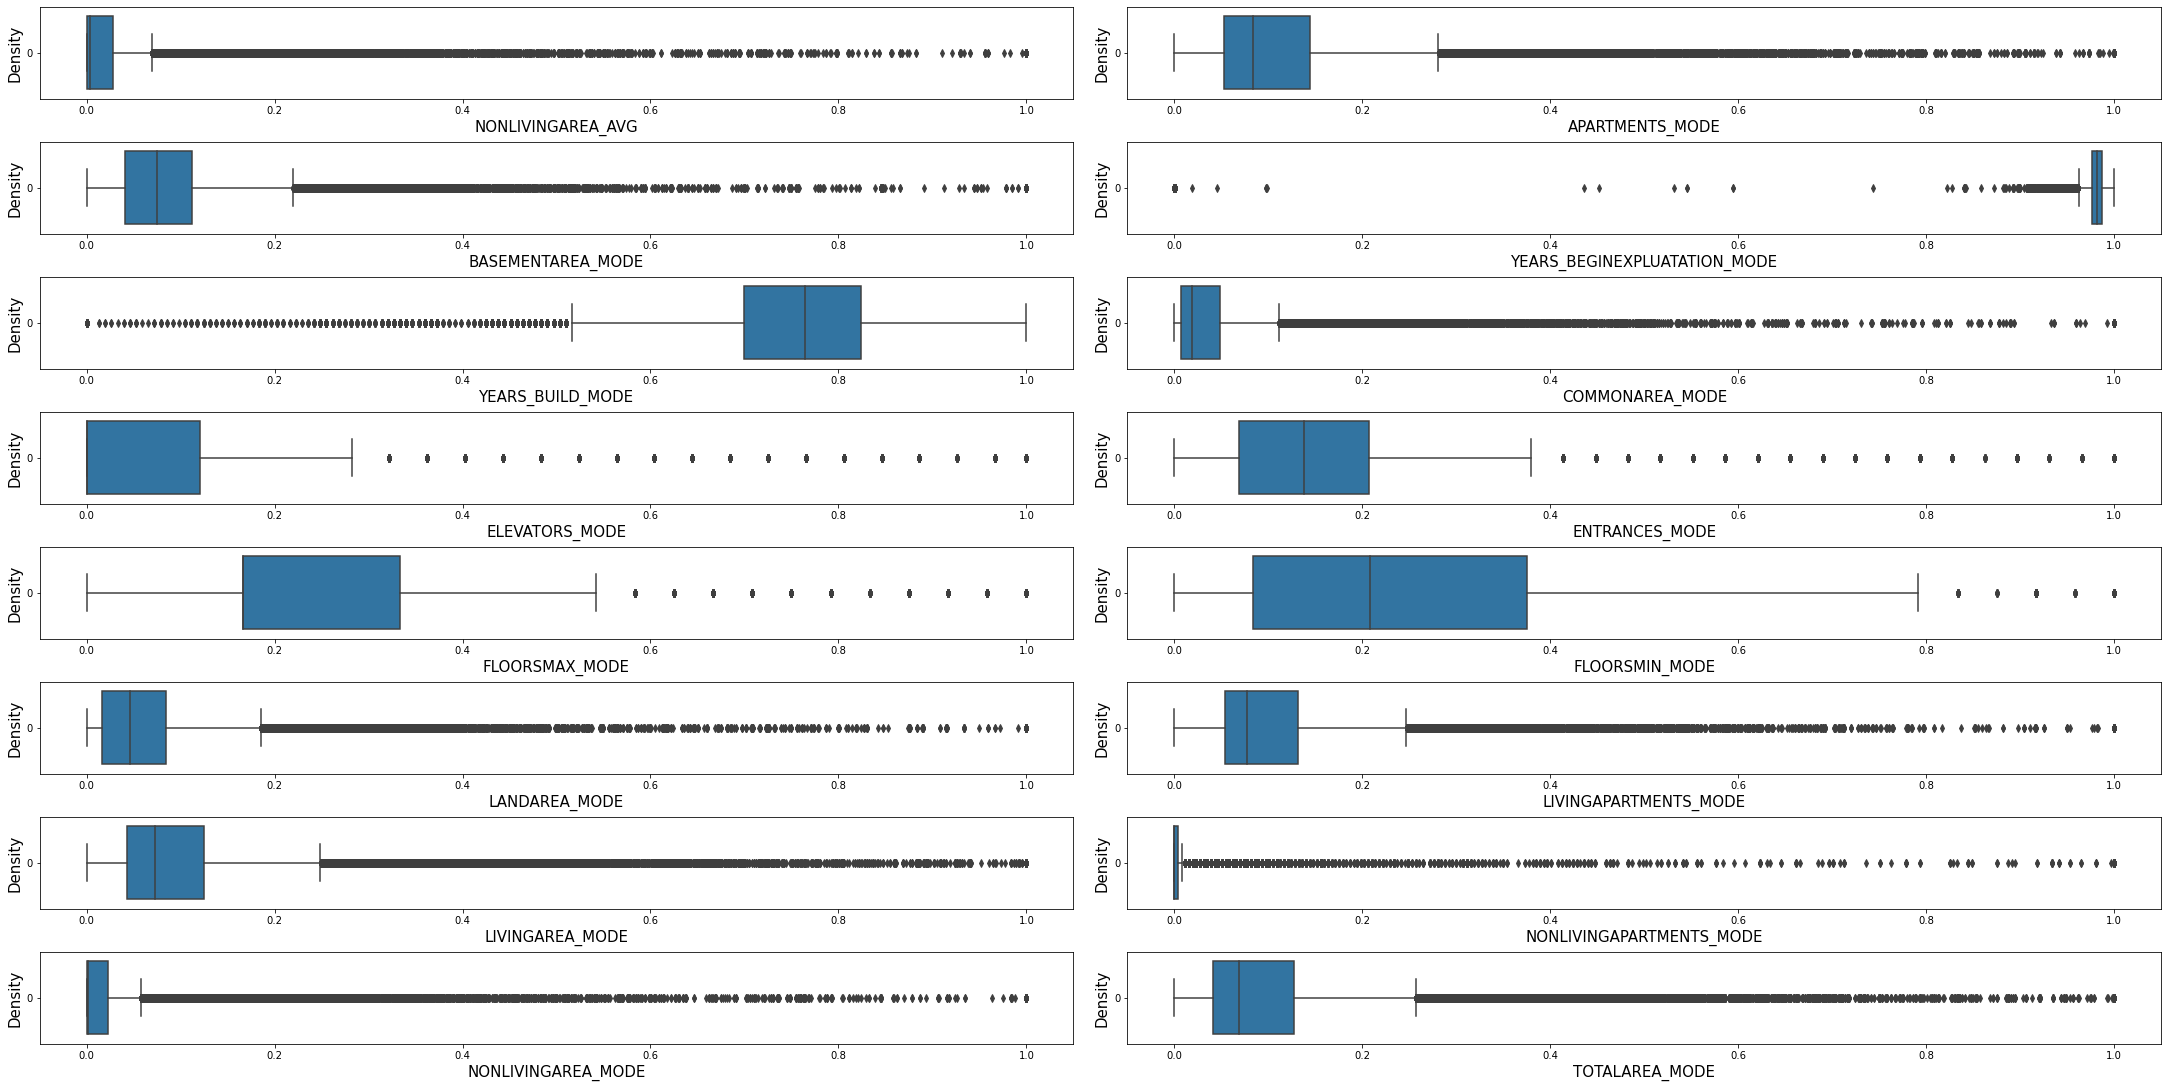

In [29]:
cols = ['NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'TOTALAREA_MODE']
plot_density(df_train, columns = cols, dt = DensityTypes.Boxplot)

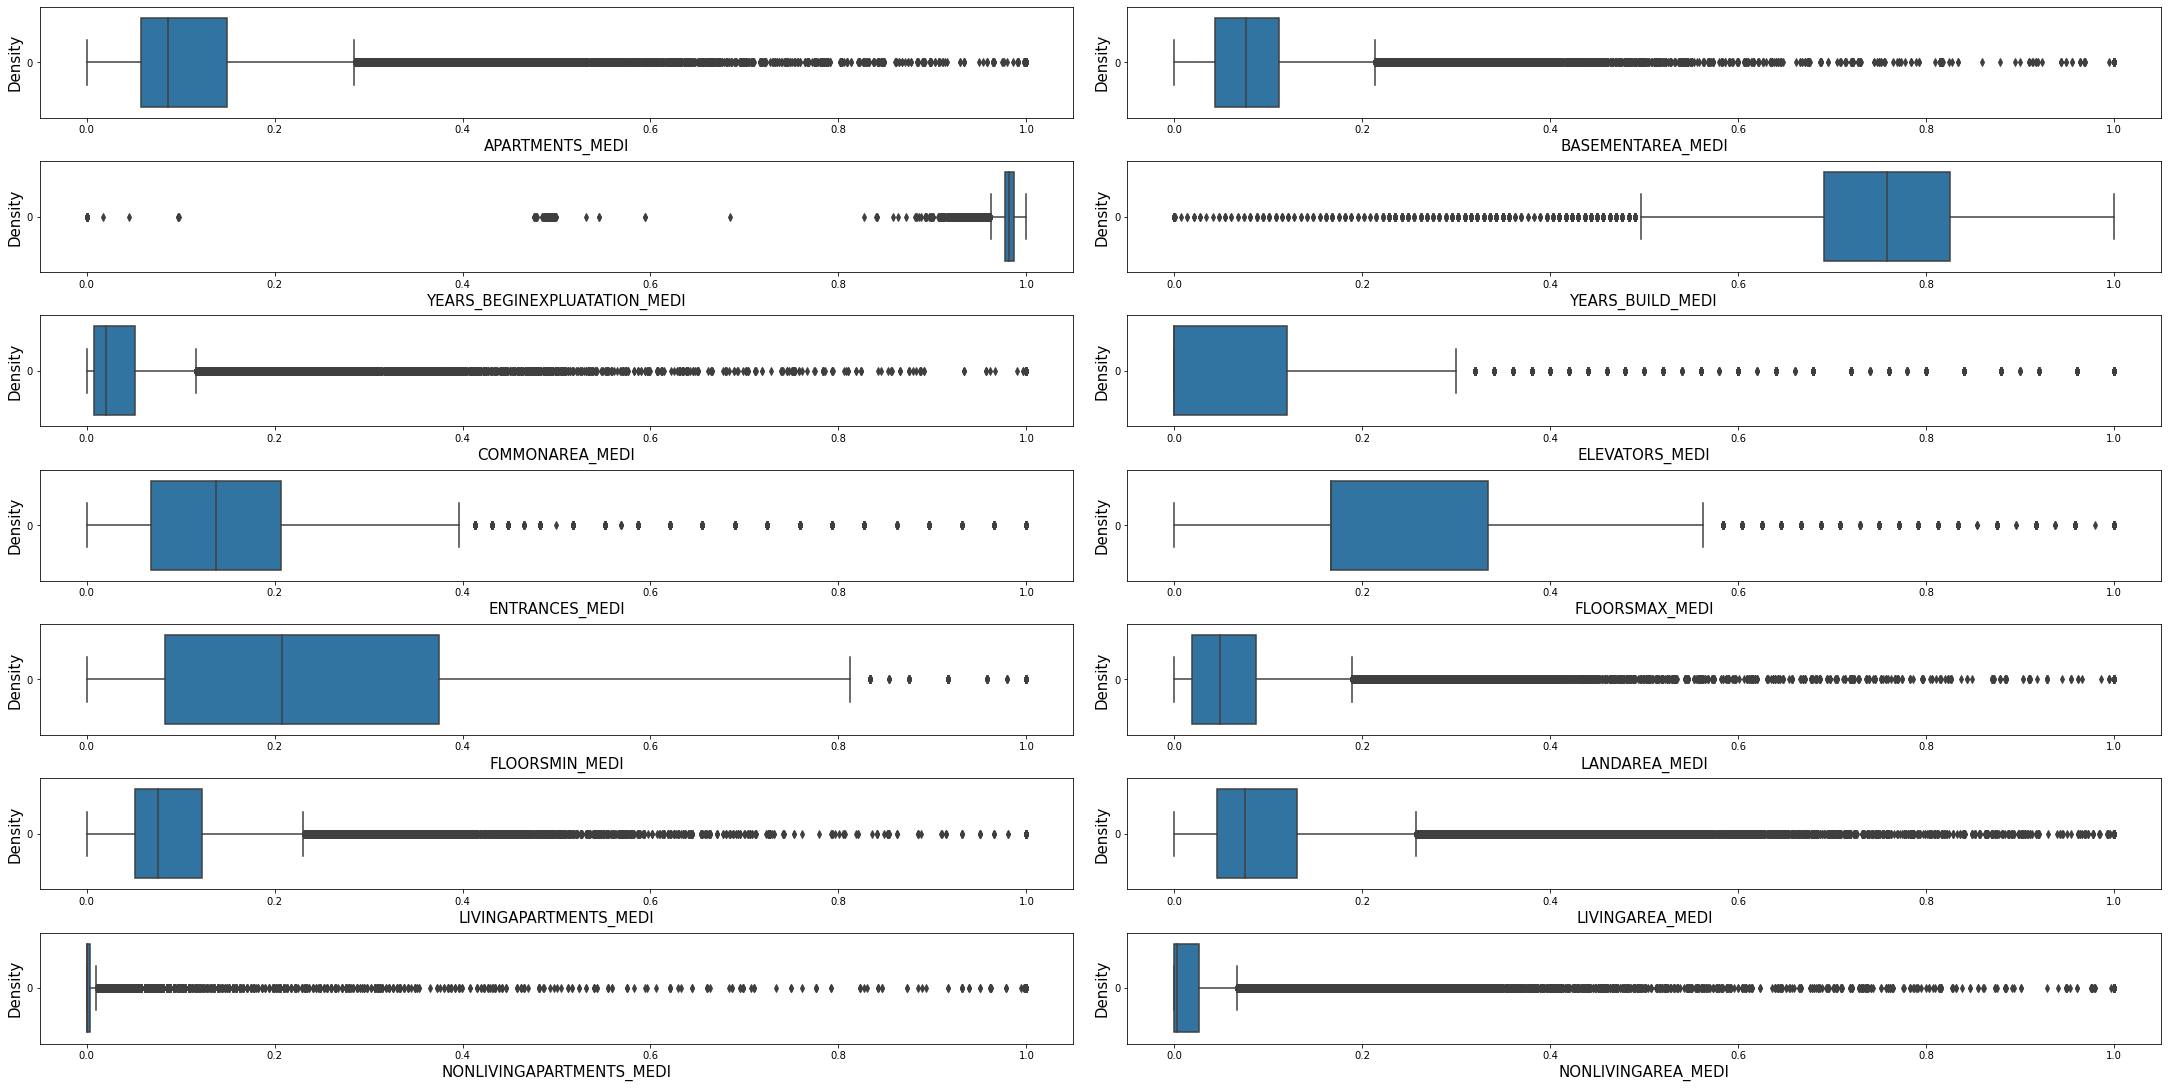

In [28]:
cols = ['APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
       'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI']
plot_density(df_train, columns = cols, dt = DensityTypes.Boxplot)

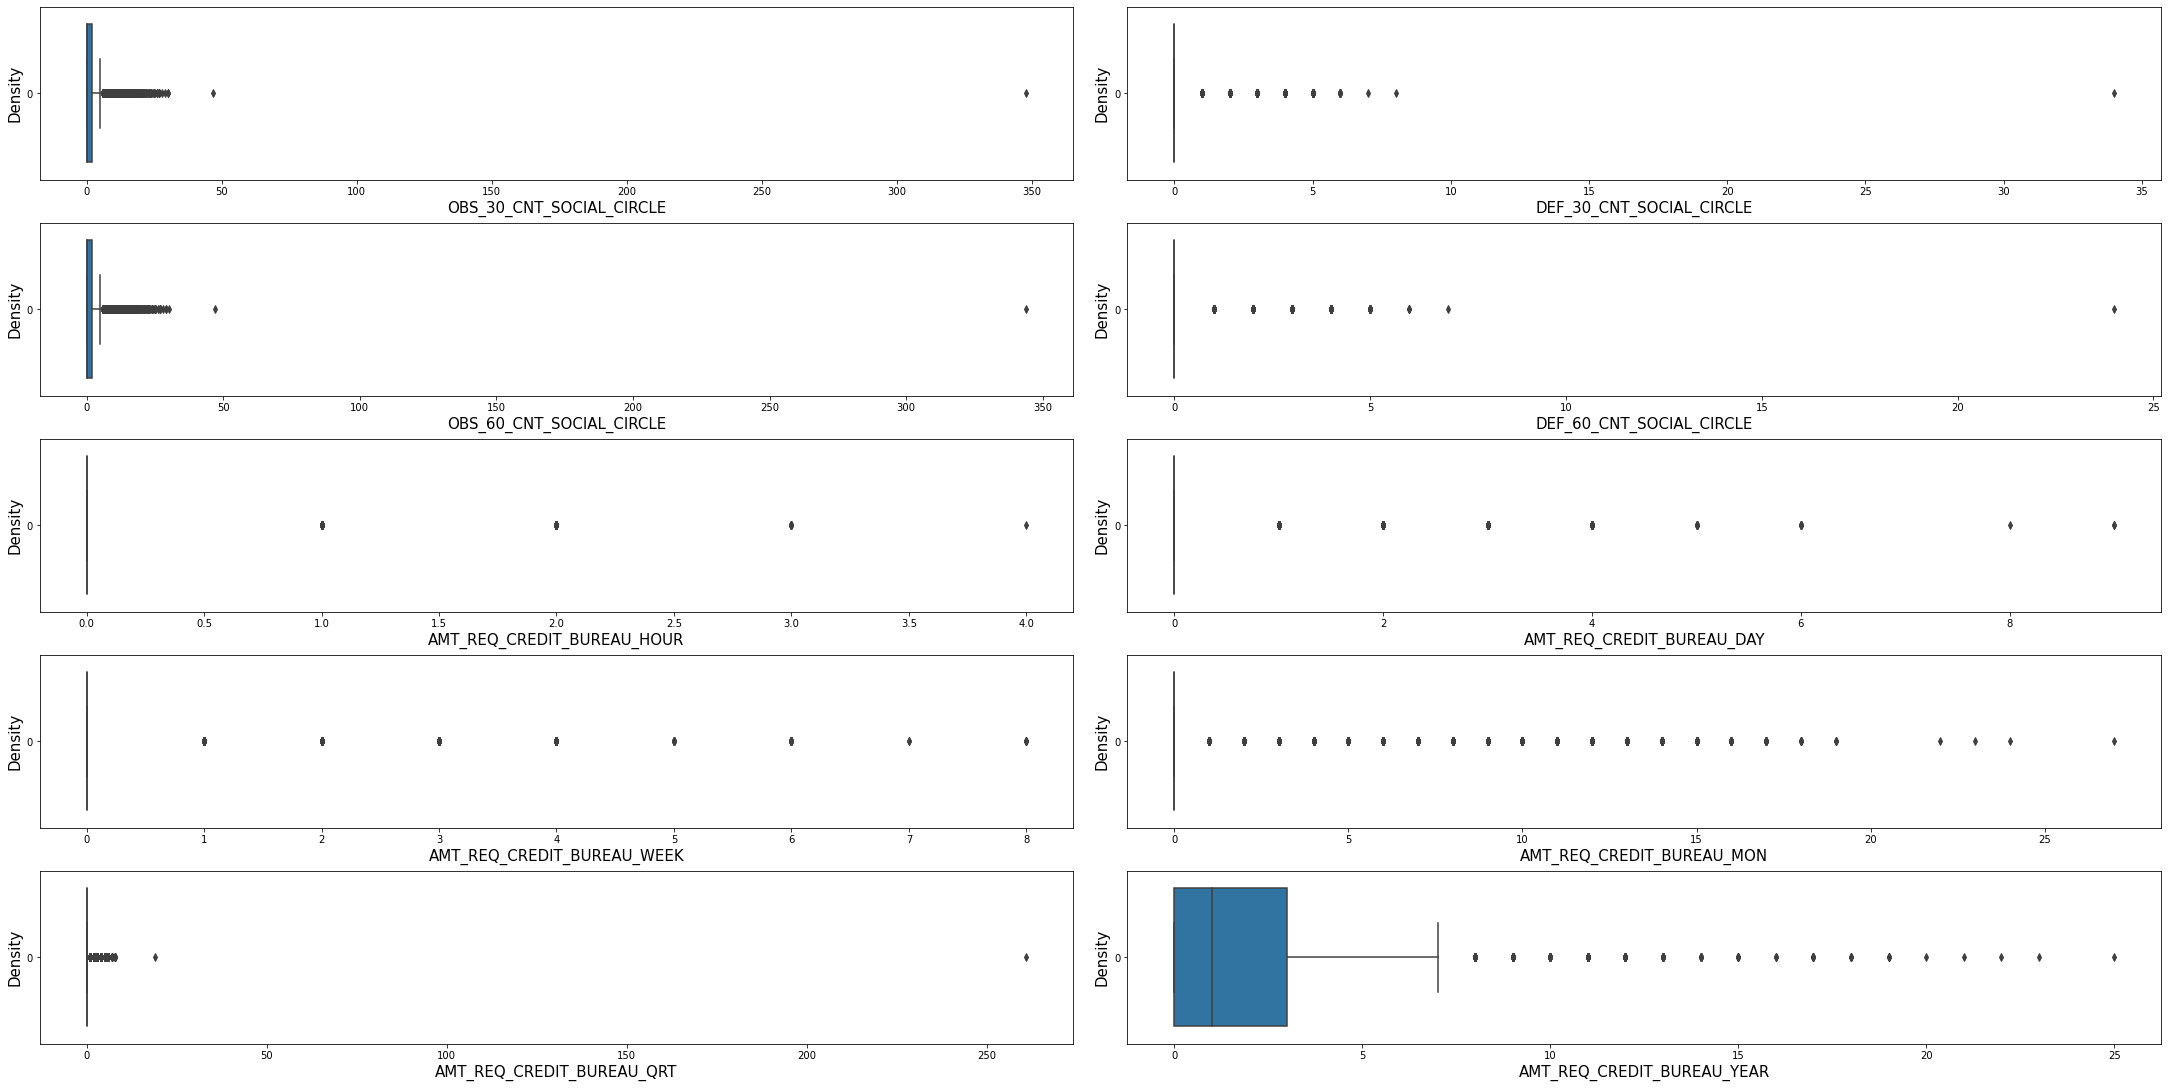

In [33]:
cols = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
plot_density(df_train, columns = cols, dt = DensityTypes.Boxplot)

# Encoding Categorical Variables

 - ***Label encoding***: assign each unique category in a categorical variable with an integer. No new columns are created. An example is shown below
 
 - ***One-hot encoding***: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.
 
If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option. Therefore for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding. For label encoding, we use the Scikit-Learn LabelEncoder and for one-hot encoding, the pandas get_dummies(df) function.

In [27]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df_train:
    if df_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(df_train[col])
            # Transform both training and testing data
            df_train[col] = le.transform(df_train[col])
            df_test[col] = le.transform(df_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

LabelEncoder()

LabelEncoder()

LabelEncoder()

3 columns were label encoded.


In [28]:
# one-hot encoding of categorical variables
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

print('Training Features shape: ', df_train.shape)
print('Testing Features shape: ', df_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


## Aligning Training and Testing Data

We need to have the same variables in the training and testing dataset. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to align the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set `axis = 1` to align the dataframes based on the columns and not on the rows!

In [29]:
train_labels = df_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)

# Add the target back in
df_train['TARGET'] = train_labels

print('Training Features shape: ', df_train.shape)
print('Testing Features shape: ', df_test.shape)

del df_test

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try dimensionality reduction (removing features that are not relevant) to reduce the size of the datasets.

# Anomalies and Data Cleaning

### Application train describe

In [18]:
df_train.describe()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.095213,0.340108,0.693673,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,...,0.030090,0.007466,0.005785,0.005284,0.214757,0.210773,0.017437,0.518446,0.007570,0.080729
std,102790.175348,0.293509,0.473746,0.460968,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,...,0.170835,0.086085,0.075840,0.072501,0.410654,0.407858,0.130892,0.499660,0.086679,0.272419
min,100002.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,456255.000000,1.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Having lots of columns we could describe the variables we are interested in. The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:

### Outliers and bad values

#### df_train : DAYS_BIRTH

In [19]:
(df_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment?

#### df_train : DAYS_EMPLOYED

In [20]:
df_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years!

In [21]:
len(df_train[(df_train['DAYS_EMPLOYED']>0) & (df_train['DAYS_EMPLOYED']!=365243)].DAYS_EMPLOYED)

0

In [22]:
anom = df_train[df_train['DAYS_EMPLOYED'] == 365243]
non_anom = df_train[df_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

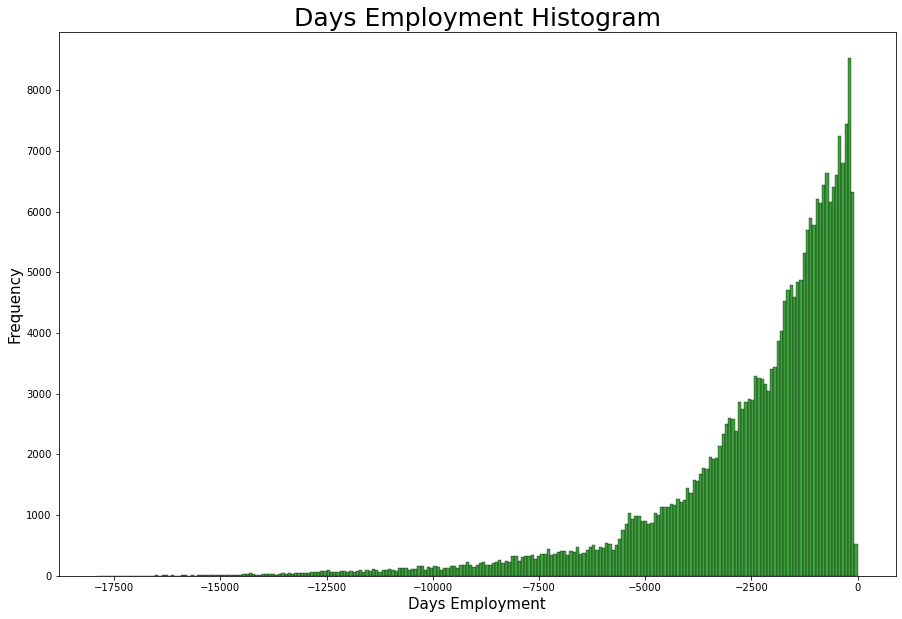

In [18]:
# Create an anomalous flag column
df_train['DAYS_EMPLOYED_ANOM'] = df_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
df_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


fig = plt.figure(figsize=(15, 10));
sns.histplot(data = df_train['DAYS_EMPLOYED'], kde=False, color='green');
plt.title('Days Employment Histogram',fontsize=25);
plt.xlabel('Days Employment',fontsize=15);
plt.ylabel('Frequency',fontsize=15);
plt.show();

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (becuase we will have to fill in the nans with some value, probably the median of the column). The other columns with DAYS in the dataframe look to be about what we expect with no obvious outliers.

## Correlations

One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

 - .00-.19 “very weak”
 - .20-.39 “weak”
 - .40-.59 “moderate”
 - .60-.79 “strong”
 - .80-1.0 “very strong”

In [31]:
correlations = df_train.corr()['TARGET'].sort_values()

In [32]:
dd_most_negative = pd.DataFrame(correlations.head(15))
dd_most_positive = pd.DataFrame(correlations.tail(15))
frames = [dd_most_negative, dd_most_positive]
correlations_margins = pd.concat(frames)
del dd_most_negative, dd_most_positive, frames

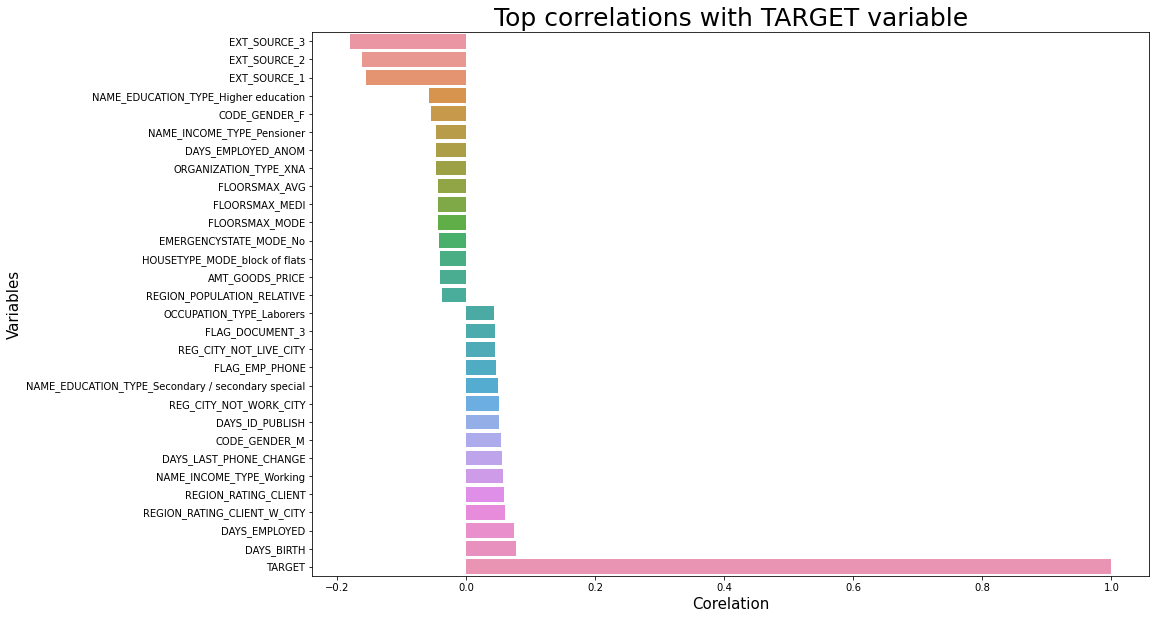

In [33]:
fig = plt.figure(figsize=(15, 10));
sns.barplot(y = correlations_margins.index, x = 'TARGET', data = correlations_margins )
plt.title('Top correlations with TARGET variable',fontsize=25);
plt.xlabel('Corelation',fontsize=15);
plt.ylabel('Variables',fontsize=15);

Let's take a look at some of more significant correlations: the DAYS_BIRTH is the most positive correlation. (except for TARGET because the correlation of a variable with itself is always 1!) Looking at the documentation, DAYS_BIRTH is the age in days of the client at the time of the loan in negative days (for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

### Effect of Age on Repayment

In [34]:
# Find the correlation of the positive days since birth and target
df_train['DAYS_BIRTH'] = abs(df_train['DAYS_BIRTH'])
df_train['DAYS_BIRTH'].corr(df_train['TARGET'])

-0.07823930830982737

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

/Users/marius/opt/anaconda3/envs/oc4/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


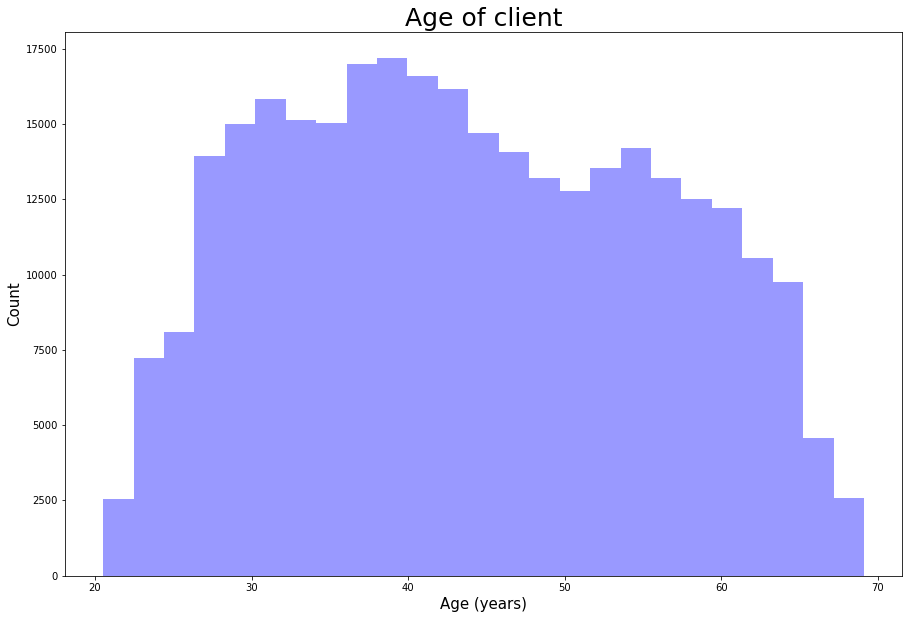

In [35]:
fig = plt.figure(figsize=(15, 10));
sns.distplot(df_train['DAYS_BIRTH'] / 365, kde=False, color='blue', bins = 25);
plt.title('Age of client',fontsize=25);
plt.xlabel('Age (years)',fontsize=15);
plt.ylabel('Count',fontsize=15);

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a kernel density estimation plot (KDE) colored by the value of the target. A kernel density estimate plot shows the distribution of a single variable and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn kdeplot for this graph.

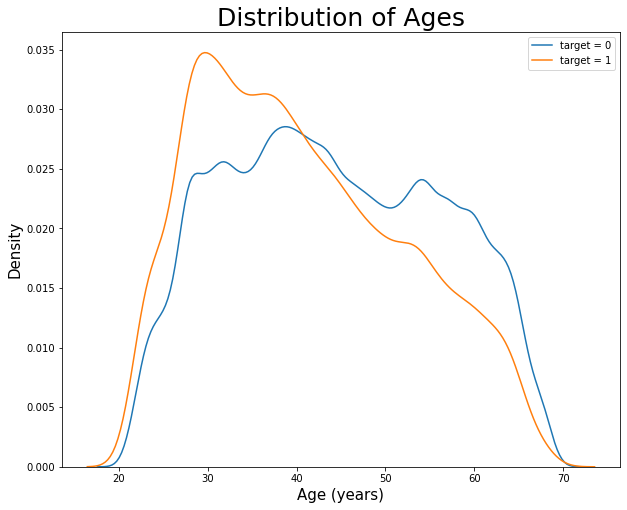

In [36]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target = 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target = 1')

# Labeling of plot
plt.xlabel('Age (years)',fontsize=15); 
plt.ylabel('Density',fontsize=15); 
plt.title('Distribution of Ages',fontsize=25);
plt.legend();

The target = 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [37]:
# Age information into a separate dataframe
age_data = df_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

/var/folders/sn/fjsn8r8j297d86mnz5vgqx5h0000gn/T/ipykernel_39646/1924181040.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
/var/folders/sn/fjsn8r8j297d86mnz5vgqx5h0000gn/T/ipykernel_39646/1924181040.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [38]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


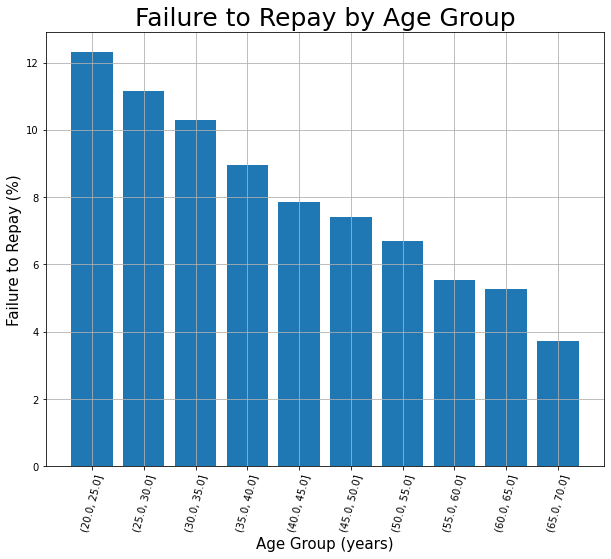

In [39]:
plt.figure(figsize = (10, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); 
plt.grid() 
plt.xlabel('Age Group (years)',fontsize=15); 
plt.ylabel('Failure to Repay (%)',fontsize=15)
plt.title('Failure to Repay by Age Group',fontsize=25);

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

### Exterior sources

The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. According to the documentation, these features represent a "normalized score from external data source". Not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data.

Let's take a look at these variables.

First, we can show the correlations of the EXT_SOURCE features with the target and with each other.

In [40]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = df_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
plot_correlation(ext_data)

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,nan,nan,nan,nan,nan
EXT_SOURCE_1,-0.155317,nan,nan,nan,nan
EXT_SOURCE_2,-0.160472,0.213982,nan,nan,nan
EXT_SOURCE_3,-0.178919,0.186846,0.109167,nan,nan
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,nan


All three EXT_SOURCE featureshave negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

<Figure size 720x864 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='EXT_SOURCE_1', ylabel='Density'>

<AxesSubplot:xlabel='EXT_SOURCE_1', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of EXT_SOURCE_1 by Target Value')

Text(0.5, 0, 'EXT_SOURCE_1')

Text(0, 0.5, 'Density')

<AxesSubplot:>

<AxesSubplot:xlabel='EXT_SOURCE_2', ylabel='Density'>

<AxesSubplot:xlabel='EXT_SOURCE_2', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of EXT_SOURCE_2 by Target Value')

Text(0.5, 0, 'EXT_SOURCE_2')

Text(0, 0.5, 'Density')

<AxesSubplot:>

<AxesSubplot:xlabel='EXT_SOURCE_3', ylabel='Density'>

<AxesSubplot:xlabel='EXT_SOURCE_3', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of EXT_SOURCE_3 by Target Value')

Text(0.5, 0, 'EXT_SOURCE_3')

Text(0, 0.5, 'Density')

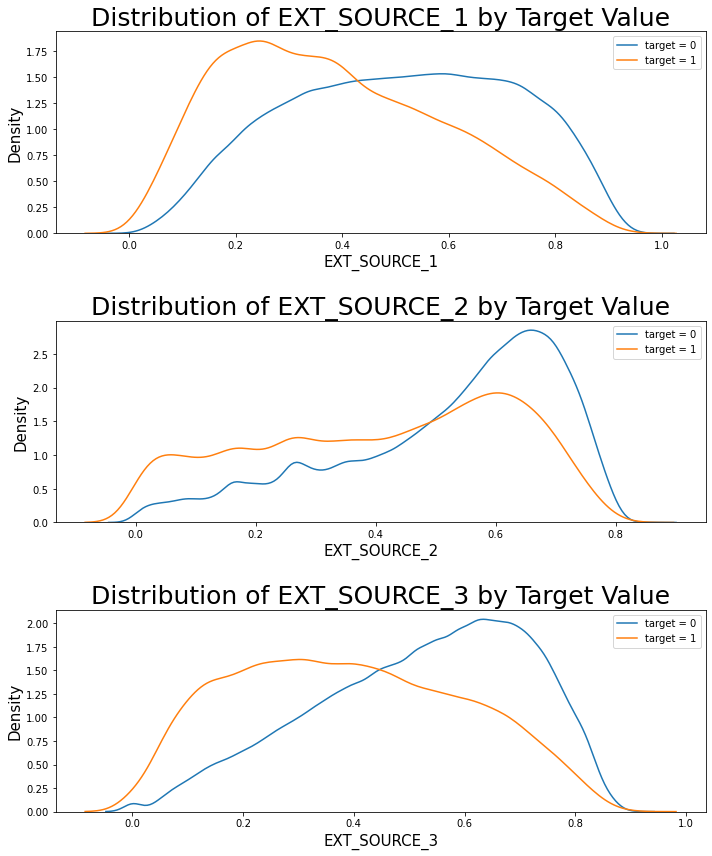

In [48]:
plt.figure(figsize = (10, 12));

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1);
    # plot repaid loans
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, source], label = 'target = 0');
    # plot loans that were not repaid
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, source], label = 'target = 1');
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source, fontsize=25);
    plt.xlabel('%s' % source, fontsize=15); 
    plt.ylabel('Density',fontsize=15);
    plt.legend();
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

# Feature Engineering

Feature engineering: those win are those who can create the most useful features out of the data. (This is true for the most part as the winning models, at least for structured data, all tend to be variants on gradient boosting). This represents one of the patterns in machine learning: feature engineering has a greater return on investment than model building and hyperparameter tuning. This is a great article on the subject). As Andrew Ng is fond of saying: "applied machine learning is basically feature engineering.".

While choosing the right model and optimal settings are important, the model can only learn from the data it is given. Making sure this data is as relevant to the task as possible is the job of the data scientist (and maybe some automated tools to help us out).

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

In the proposed  kernel Kaggle, two simple feature construction methods:

 - Polynomial features
 - Domain knowledge features

## Polynomial features 

One simple feature construction method is called polynomial features. In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can create variables `EXT_SOURCE_1`^2 and `EXT_SOURCE_2`^2 and also variables such as `EXT_SOURCE_` x `EXT_SOURCE_2`, `EXT_SOURCE_1` x `EXT_SOURCE_2`^2, `EXT_SOURCE_1`^2 x  `EXT_SOURCE_2`^2, and so on. These features that are a combination of multiple individual variables are called interaction terms because they capture the interactions between variables. In other words, while two variables by themselves may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. Interaction terms are commonly used in statistical models to capture the effects of multiple variables. Theese are not used as often in machine learning. Nonetheless, we can try out a few to see if they might help our model to predict whether or not a client will repay a loan.



In the following code, we create polynomial features using the `EXT_SOURCE` variables and the `DAYS_BIRTH` variable. Scikit-Learn has a useful class called PolynomialFeatures that creates the polynomials and the interaction terms up to a specified degree. We can use a degree of 3 to see the results (when we are creating polynomial features, we want to avoid using too high of a degree, both because the number of features scales exponentially with the degree, and because we can run into problems with overfitting).

In [56]:
# Make a new dataframe for polynomial features
poly_features = df_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = df_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [57]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

PolynomialFeatures(degree=3)

Polynomial Features shape:  (307511, 35)


This creates a considerable number of new features. To get the names we have to use the polynomial features get_feature_names method.

In [58]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

/Users/marius/opt/anaconda3/envs/oc4/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

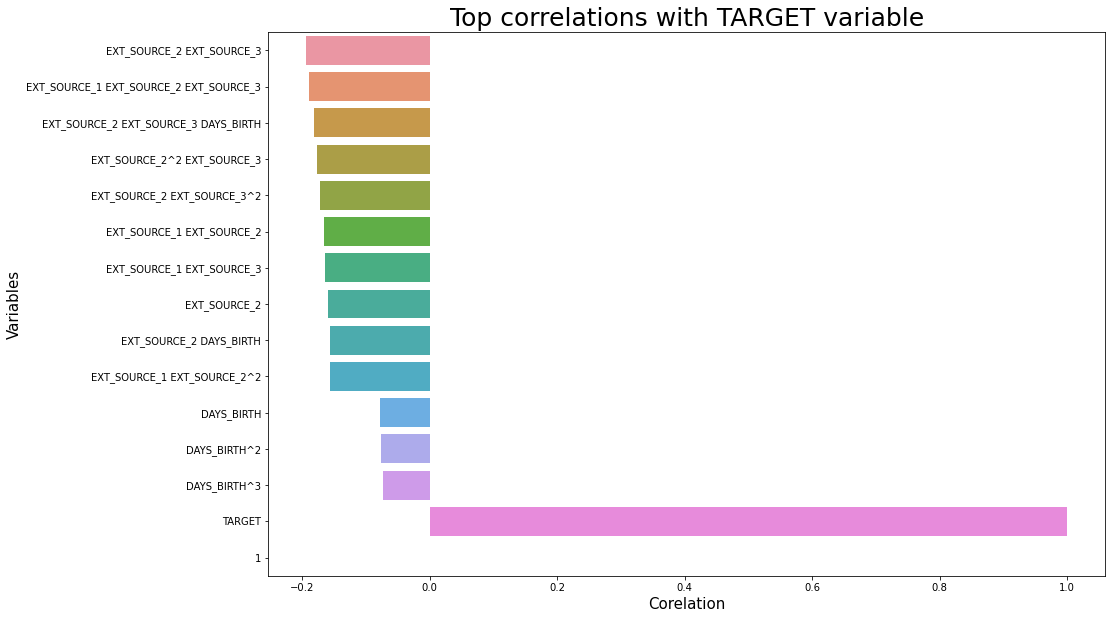

In [59]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()


dd_most_negative = pd.DataFrame(poly_corrs.head(10))
dd_most_positive = pd.DataFrame(poly_corrs.tail(5))
frames = [dd_most_negative, dd_most_positive]
correlations_margins = pd.concat(frames)
del dd_most_negative, dd_most_positive, frames


fig = plt.figure(figsize=(15, 10));
sns.barplot(y = correlations_margins.index, x = 'TARGET', data = correlations_margins )
plt.title('Top correlations with TARGET variable',fontsize=25);
plt.xlabel('Corelation',fontsize=15);
plt.ylabel('Variables',fontsize=15);

Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn.

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out!

In [62]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = df_train['SK_ID_CURR']
app_train_poly = df_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = df_test['SK_ID_CURR']
app_test_poly = df_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

/Users/marius/opt/anaconda3/envs/oc4/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


## Domain knowledge features

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by this script by Aguiar:

 - `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
 - `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
 - `CREDIT_TERM`: the length of the payment in months (since the annuity is the monthly amount due
 - `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

In [63]:
app_train_domain = df_train.copy()
app_test_domain = df_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [64]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

### Visualize the new variables
We should explore these domain knowledge variables visually in a graph. For all of these, we will make the same KDE plot colored by the value of the TARGET.

<Figure size 864x1440 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='CREDIT_INCOME_PERCENT', ylabel='Density'>

<AxesSubplot:xlabel='CREDIT_INCOME_PERCENT', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of CREDIT_INCOME_PERCENT by Target Value')

Text(0.5, 0, 'CREDIT_INCOME_PERCENT')

Text(0, 0.5, 'Density')

<AxesSubplot:>

<AxesSubplot:xlabel='ANNUITY_INCOME_PERCENT', ylabel='Density'>

<AxesSubplot:xlabel='ANNUITY_INCOME_PERCENT', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of ANNUITY_INCOME_PERCENT by Target Value')

Text(0.5, 0, 'ANNUITY_INCOME_PERCENT')

Text(0, 0.5, 'Density')

<AxesSubplot:>

<AxesSubplot:xlabel='CREDIT_TERM', ylabel='Density'>

<AxesSubplot:xlabel='CREDIT_TERM', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of CREDIT_TERM by Target Value')

Text(0.5, 0, 'CREDIT_TERM')

Text(0, 0.5, 'Density')

<AxesSubplot:>

<AxesSubplot:xlabel='DAYS_EMPLOYED_PERCENT', ylabel='Density'>

<AxesSubplot:xlabel='DAYS_EMPLOYED_PERCENT', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of DAYS_EMPLOYED_PERCENT by Target Value')

Text(0.5, 0, 'DAYS_EMPLOYED_PERCENT')

Text(0, 0.5, 'Density')

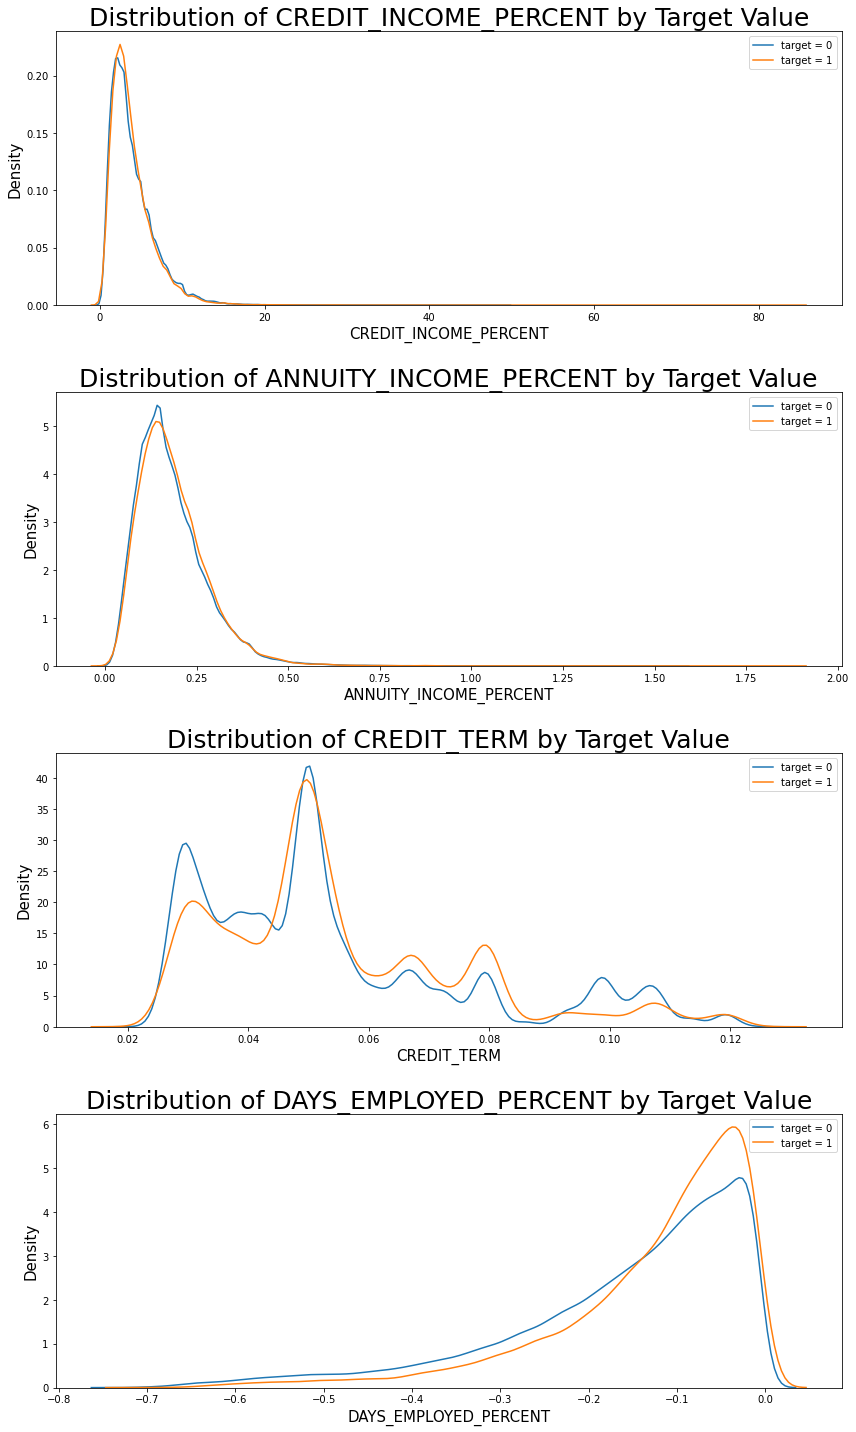

In [66]:
plt.figure(figsize = (12, 20));
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1);
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target = 0');
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target = 1');
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature,fontsize=25);
    plt.xlabel('%s' % feature,fontsize=15); 
    plt.ylabel('Density',fontsize=15);
    plt.legend();
    
plt.tight_layout(h_pad = 2.5)

It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to try them out!

# Baseline

For a naive baseline, we could guess the same value for all examples on the testing set. We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This will get us a Reciever Operating Characteristic Area Under the Curve (AUC ROC) of 0.5 in the competition (random guessing on a classification task will score a 0.5).

Since we already know what score we are going to get, we don't really need to make a naive baseline guess. Let's use a slightly more sophisticated model for our actual baseline: Logistic Regression.

## Logistic Regression Implementation

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

In [104]:

# Drop the target from the training data
if 'TARGET' in df_train:
    train = df_train.drop(columns = ['TARGET'])
else:
    train = df_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = df_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(df_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

SimpleImputer(strategy='median')

MinMaxScaler()

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


We will use LogisticRegressionfrom Scikit-Learn for our first model. The only change we will make from the default model settings is to lower the regularization parameter, C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default LogisticRegression, but it still will set a low bar for any future models.

Here we use the familiar Scikit-Learn modeling syntax: we first create the model, then we train the model using .fit and then we make predictions on the testing data using .predict_proba (remember that we want probabilities and not a 0 or 1).

In [105]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001)

Now that the model has been trained, we can use it to make predictions. We want to predict the probabilities of not paying a loan, so we use the model predict.proba method. This returns an m x 2 array where m is the number of observations. The first column is the probability of the target being 0 and the second column is the probability of the target being 1 (so for a single row, the two columns must sum to 1). We want the probability the loan is not repaid, so we will select the second column.

The following code makes the predictions and selects the correct column.

In [106]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

The predictions must be in the format shown in the sample_submission.csv file, where there are only two columns: `SK_ID_CURR` and `TARGET`. We will create a dataframe in this format from the test set and the predictions called submit.

In [107]:
# Submission dataframe
submit = df_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

/var/folders/sn/fjsn8r8j297d86mnz5vgqx5h0000gn/T/ipykernel_39646/1245558468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['TARGET'] = log_reg_pred


,SK_ID_CURR,TARGET
0,100001,0.078515
1,100005,0.137926
2,100013,0.082194
3,100028,0.080921
4,100038,0.132618


In [108]:
# Save the submission to a csv file
# submit.to_csv('log_reg_baseline.csv', index = False)

In [111]:
log_reg.score(train, train_labels)

0.9192711805431351

In [ ]:
pd.crosstab(pd.Series(log_reg_pred, name = 'Predicted'),
            pd.Series(test

***The logistic regression baseline should score around 0.671.***

## Make Predictions using Engineered Features

The only way to see if the Polynomial Features and Domain knowledge improved the model is to train a test a model on these features! We can then compare the submission performance to that for the model without these features to gauge the effect of our feature engineering.

In [84]:
poly_features_names = list(app_train_poly.columns)

# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

# Make the model with the specified regularization parameter
log_reg_poly = LogisticRegression(C = 0.0001)

In [86]:
# Train on the training data
log_reg_poly.fit(poly_features, train_labels)

# Make predictions on the test data
predictions = log_reg_poly.predict_proba(poly_features_test)[:, 1]

LogisticRegression(C=0.0001)

In [89]:
# Make a submission dataframe
submit = df_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

submit.head()
# Save the submission dataframe
# submit.to_csv('random_forest_baseline_engineered.csv', index = False)

/var/folders/sn/fjsn8r8j297d86mnz5vgqx5h0000gn/T/ipykernel_39646/2574564088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['TARGET'] = predictions


,SK_ID_CURR,TARGET
0,100001,0.101757
1,100005,0.196251
2,100013,0.094320
3,100028,0.104534
4,100038,0.178349


In [96]:
log_reg_poly.score(poly_features, train_labels)

0.9192711805431351

In [98]:
log_reg_poly.score(poly_features_test, predictions)

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [99]:
poly_features_test.shape

(48744, 275)

In [100]:
predictions.shape

(48744,)

In [101]:
poly_features.shape

(307511, 275)

In [102]:
train_labels.shape

(307511,)